# Imputation Methods

Last update 9/23/2025


# Before Imputing Missing
Cases with missing values are removed. Then a summary of data is generated. 5-fold cross validation is tested. Random seeds are generated and stored.

In [2]:
!pip install missforest

In [3]:
!pip install miceforest

In [4]:
## Loading required libraries

import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import KFold, train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error
from missforest import MissForest
import miceforest as mf
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [5]:
# ----------------------------------------------------
# A. GLOBAL VARIABLE FOR CATEGORICAL COLUMNS
# This list tells the evaluation function which columns to check for PFC.
# ----------------------------------------------------

IMPUTATION_CATEGORICAL_COLS = [
    "male",
    "currentSmoker",
    "education",
    "BPMeds",
    "prevalentStroke",
    "prevalentHyp",
    "diabetes"
]

# ----------------------------------------------------
# B. EVALUATION FUNCTION DEFINITION
# This function calculates NRMSE/RMSE and PFC per variable.
# NOTE: It requires 'x' (your ground truth) and 'data_x' (your missing data) to be available.
# ----------------------------------------------------

IMPUTED_RESULTS = {}
def evaluate_imputation(x_true, x_missing, x_imputed, categorical_cols):
    """
    Calculates performance metrics (NRMSE/RMSE/PFC) for each variable
    and returns a summary DataFrame.
    """
    results = []

    # Identify continuous columns
    continuous_cols = [col for col in x_true.columns if col not in categorical_cols]

    # Iterate through all columns that had missing values
    for col in x_missing.columns[x_missing.isnull().any()]:

        # 1. Identify the indices where the data was originally missing
        missing_indices = x_missing[col].isnull()

        # Get the true values (Ground Truth) and imputed values only at missing locations
        true_values = x_true.loc[missing_indices, col].copy()
        imputed_values = x_imputed.loc[missing_indices, col].copy()

        # Ensure we only compare values that were actually missing
        if len(true_values) == 0:
            continue

        if col in categorical_cols:
            # --- CATEGORICAL METRIC (PFC) ---
            # Ensure proper type conversion for comparison
            mismatches = (true_values.astype(int) != imputed_values.astype(int)).sum()
            pfc = mismatches / len(true_values)
            results.append({
                'Variable': col,
                'Type': 'Categorical',
                'RMSE': np.nan,
                'NRMSE': np.nan,
                'PFC': pfc,
                'Imputed_Count': len(true_values)
            })

        else:
            # --- CONTINUOUS METRICS (RMSE & NRMSE) ---
            rmse = np.sqrt(mean_squared_error(true_values, imputed_values))

            # Normalize by the standard deviation of the true data
            std_dev = x_true[col].std()
            nrmse = rmse / std_dev

            results.append({
                'Variable': col,
                'Type': 'Continuous',
                'RMSE': rmse,
                'NRMSE': nrmse,
                'PFC': np.nan,
                'Imputed_Count': len(true_values)
            })

    # Return the summary table
    summary_df = pd.DataFrame(results).set_index('Variable')

    # Calculate the overall NRMSE/PFC scores for the header
    overall_nrmse = summary_df.loc[summary_df['Type'] == 'Continuous', 'NRMSE'].mean()
    overall_pfc_num = summary_df.loc[summary_df['Type'] == 'Categorical', 'PFC'] * summary_df.loc[summary_df['Type'] == 'Categorical', 'Imputed_Count']
    overall_pfc_den = summary_df.loc[summary_df['Type'] == 'Categorical', 'Imputed_Count'].sum()
    overall_pfc = overall_pfc_num.sum() / overall_pfc_den

    print(f"\n--- OVERALL RESULTS (MEDIAN) ---")
    print(f"Average NRMSE (Continuous): {overall_nrmse:.4f}")
    print(f"Overall PFC (Categorical): {overall_pfc:.4f}")
    print("--------------------------------\n")

    return summary_df

In [6]:
## Function to generate summary statistics

def summary_stats(df):
    stats = df.agg(['count', 'min', 'max', 'mean', 'std', pd.Series.skew]).rename(
        {'count': 'total_cases',
         'min': 'min',
         'max': 'max',
         'mean': 'average',
         'std': 'standard_deviation',
         'skew': 'skewness'}).T

    zeros = (df == 0).sum()
    missing = df.isnull().sum()
    stats['complete_cases_percent'] = (1 - missing / len(df)) * 100
    stats['missing_total'] = missing
    stats['missing_percent'] = (missing / len(df)) * 100
    stats['zero_count'] = zeros
    stats['zero_percent'] = (zeros / len(df)) * 100

    return stats.round(3)

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
## Loading data
df = pd.read_csv('/content/drive/MyDrive/Monticello_Saghafi_HonorsThesis/framingham.csv')
print('Total duplicates:', df.duplicated().sum())
print('The duplicates have different IDs, so they belong to different people and therefore are not removed')
print('Total missing values:', df.isnull().sum().sum())
print('Percentage missing values:', 100*df.isnull().sum().sum()/(df.shape[0]*df.shape[1]))
summary_stats(df)

Total duplicates: 0
The duplicates have different IDs, so they belong to different people and therefore are not removed
Total missing values: 645
Percentage missing values: 0.9507665094339622


total_cases     min    max  average  standard_deviation  \
male                  4240.0    0.00    1.0    0.429               0.495   
age                   4240.0   32.00   70.0   49.580               8.573   
education             4135.0    1.00    4.0    1.979               1.020   
currentSmoker         4240.0    0.00    1.0    0.494               0.500   
cigsPerDay            4211.0    0.00   70.0    9.006              11.922   
BPMeds                4187.0    0.00    1.0    0.030               0.170   
prevalentStroke       4240.0    0.00    1.0    0.006               0.077   
prevalentHyp          4240.0    0.00    1.0    0.311               0.463   
diabetes              4240.0    0.00    1.0    0.026               0.158   
totChol               4190.0  107.00  696.0  236.700              44.591   
sysBP                 4240.0   83.50  295.0  132.355              22.033   
diaBP                 4240.0   48.00  142.5   82.898              11.910   
BMI                   4221.0   15.54   56.8   25.801               4.080   
heartRate             4239.0   44.00  143.0   75.879              12.025   
glucose               3852.0   40.00  394.0   81.964              23.954   
TenYearCHD            4240.0    0.00    1.0    0.152               0.359   

                 skewness  complete_cases_percent  missing_total  \
male                0.286                 100.000              0   
age                 0.229                 100.000              0   
education           0.689                  97.524            105   
currentSmoker       0.024                 100.000              0   
cigsPerDay          1.247                  99.316             29   
BPMeds              5.551                  98.750             53   
prevalentStroke    12.912                 100.000              0   
prevalentHyp        0.819                 100.000              0   
diabetes            5.996                 100.000              0   
totChol             0.872                  98.821             50   
sysBP               1.145                 100.000              0   
diaBP               0.713                 100.000              0   
BMI                 0.982                  99.552             19   
heartRate           0.644                  99.976              1   
glucose             6.215                  90.849            388   
TenYearCHD          1.941                 100.000              0   

                 missing_percent  zero_count  zero_percent  
male                       0.000        2420        57.075  
age                        0.000           0         0.000  
education                  2.476           0         0.000  
currentSmoker              0.000        2145        50.590  
cigsPerDay                 0.684        2145        50.590  
BPMeds                     1.250        4063        95.825  
prevalentStroke            0.000        4215        99.410  
prevalentHyp               0.000        2923        68.939  
diabetes                   0.000        4131        97.429  
totChol                    1.179           0         0.000  
sysBP                      0.000           0         0.000  
diaBP                      0.000           0         0.000  
BMI                        0.448           0         0.000  
heartRate                  0.024           0         0.000  
glucose                    9.151           0         0.000  
TenYearCHD                 0.000        3596        84.811

In [9]:
## Removing cases with missing values
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3658 entries, 0 to 4239
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   male             3658 non-null   int64  
 1   age              3658 non-null   int64  
 2   education        3658 non-null   float64
 3   currentSmoker    3658 non-null   int64  
 4   cigsPerDay       3658 non-null   float64
 5   BPMeds           3658 non-null   float64
 6   prevalentStroke  3658 non-null   int64  
 7   prevalentHyp     3658 non-null   int64  
 8   diabetes         3658 non-null   int64  
 9   totChol          3658 non-null   float64
 10  sysBP            3658 non-null   float64
 11  diaBP            3658 non-null   float64
 12  BMI              3658 non-null   float64
 13  heartRate        3658 non-null   float64
 14  glucose          3658 non-null   float64
 15  TenYearCHD       3658 non-null   int64  
dtypes: float64(9), int64(7)
memory usage: 485.8 KB


In [10]:
## 1st col: response, rest: predictors, store as numpy array
y = df.iloc[:, 0].values
X = df.iloc[:, 1:].values
print('Shape of X:', X.shape, 'Shape of y:', y.shape)

Shape of X: (3658, 15) Shape of y: (3658,)


In [11]:
## Cross Validation
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=2025)

In [12]:
random_seeds = [random.randint(1, 2025) for _ in range(10)]
random_seeds.sort()
print(random_seeds)

[250, 367, 561, 680, 1098, 1153, 1166, 1218, 1228, 1745]


In [13]:
# R1
[91, 359, 377, 474, 944, 1074, 1507, 1537, 1582, 1862]

[91, 359, 377, 474, 944, 1074, 1507, 1537, 1582, 1862]

## Artificial Missing Values

y = TenYearCHD

x = remaining variables


In [14]:
## Select last column as y variable TenYearCHD.
# Get the name of the last column
y = df.columns[-1]
x = df.iloc[:, :-1].to_numpy()

print(x)
print(y)

[[  1.    39.     4.   ...  26.97  80.    77.  ]
 [  0.    46.     2.   ...  28.73  95.    76.  ]
 [  1.    48.     1.   ...  25.34  75.    70.  ]
 ...
 [  0.    52.     2.   ...  21.47  80.   107.  ]
 [  1.    40.     3.   ...  25.6   67.    72.  ]
 [  0.    39.     3.   ...  20.91  85.    80.  ]]
TenYearCHD


# Imputation Methods Sample Run

In this section each imputation method is run one time on an example dataset with missing values.

## Required Packages and Functions

In [15]:
## Helper functions

def mcar_missing(arr_cols: np.ndarray, ncols: np.ndarray, miss_rate: float, random_seed=None):
  '''Randomly delete from arr_cols (ncols=0: from the entire data, ncols>0: from a random selection of cols) to create data with MCAR.'''
  if random_seed is not None:
    np.random.seed(random_seed)
  data = arr_cols.copy()
  if ncols == 0:
    # uniform random vector
    u = np.random.uniform(size=data.shape)
    # missing values where u <= miss_rate
    mask = (u <= miss_rate)
    data[mask] = np.nan
  else:
    # Randomly select ncols columns
    selected_cols = np.random.choice(arr_cols.shape[1], ncols, replace=False)
    for col in selected_cols:
      # uniform random vector
      u = np.random.uniform(size=data.shape[0])
      # missing values where u <= miss_rate
      mask = (u <= probs)
      data[mask, col] = np.nan
  return data


def mar_missing(col_miss: np.ndarray, col_ctrl: np.ndarray, miss_rate: float, random_seed=None):
  '''Randomly delete from col_miss based on col_ctrl ranks to create data with MAR.'''
  if random_seed is not None:
    np.random.seed(random_seed)
  data = col_miss.copy()
  # Compute the percentile ranks of the ctrl column
  ranks = np.argsort(col_ctrl, axis=0).argsort(axis=0) + 1
  ranks = ranks / col_ctrl.shape[0]  # Normalize ranks
  # Calculate probabilities based on the ranks to achieve the desired missing rate
  if miss_rate <= 0.5:
    probs = 2 * miss_rate * ranks
  else:
    probs = 1 - 2 * (1 - miss_rate) * (1 - ranks)
  # uniform random vector
  u = np.random.uniform(size=data.shape)
  # missing values where u <= miss_rate
  mask = (u <= probs)
  data[mask] = np.nan
  return data


def mnar_missing(col_miss: np.ndarray, miss_rate: float, missing_on='high', random_seed=None):
  '''Randomly delete from col_miss to create data with MNAR.'''
  if random_seed is not None:
    np.random.seed(random_seed)
  data = col_miss.copy()
  # Compute the percentile ranks
  sorted_indices = np.argsort(col_miss, axis=0)
  ranks = np.empty_like(sorted_indices, dtype=float)
  ranks[sorted_indices] = (np.arange(1, col_miss.shape[0] + 1) / col_miss.shape[0])
  # Invert ranks for missing_on='low' direction
  if missing_on == 'low':
    ranks = 1 - ranks
  # Calculate probabilities based on the ranks to achieve the desired missing rate
  if miss_rate <= 0.5:
    probs = 2 * miss_rate * ranks
  else:
    probs = 1 - 2 * (1 - miss_rate) * (1 - ranks)
  # Clip probabilities to ensure they are between 0 and 1
  probs = np.clip(probs, 0, 1)
  # uniform random vector
  u = np.random.uniform(size=data.shape)
  # missing values where u <= miss_rate
  mask = (u <= probs)
  data[mask] = np.nan
  return data


def rmse_loss (full_data, data_x, imputed_data):
  '''Calculate RMSE between full_data and imputed_data for continuous missing values in data_x.'''
  #scaler = MinMaxScaler()
  #norm_parameters = scaler.fit(full_data)
  #full_data = scaler.transform(full_data)
  #imputed_data = scaler.transform(imputed_data)
  data_m = 1 - np.isnan(data_x)
  # Only for missing values
  valid_indices = (1-data_m)
  nominator = np.sum(np.square(valid_indices * (full_data - imputed_data)))
  denominator = np.sum(valid_indices)
  rmse = np.sqrt(nominator/float(denominator))
  return rmse


def round_like(df_to_round: pd.DataFrame, reference_df: pd.DataFrame) -> pd.DataFrame:
    """
    Rounds the values of df_to_round based on the number of decimal places in reference_df.
    """
    def count_decimals(val):
        try:
            decimal_part = str(val).split('.')[-1]
            return len(decimal_part) if '.' in str(val) else 0
        except:
            return 0

    # Use DataFrame.map for future compatibility
    decimal_places = reference_df.map(count_decimals)
    rounded_df = df_to_round.copy()

    for col in df_to_round.columns:
        rounded_df[col] = [
            round(val, dec) for val, dec in zip(df_to_round[col], decimal_places[col])
        ]

    return rounded_df

In [20]:
# Create data with missing values
data_x_np = mcar_missing(x, 0, 0.25, 2026)
data_x = pd.DataFrame(data_x_np, columns=df.columns[:-1]) # Use original column names, excluding the last ('TenYearCHD')

print('Shape of data_x:', data_x.shape)
print('Number of missing values:', np.count_nonzero(np.isnan(data_x)))
data_x.info()

Shape of data_x: (3658, 15)
Number of missing values: 13651
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3658 entries, 0 to 3657
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   male             2760 non-null   float64
 1   age              2740 non-null   float64
 2   education        2740 non-null   float64
 3   currentSmoker    2746 non-null   float64
 4   cigsPerDay       2790 non-null   float64
 5   BPMeds           2745 non-null   float64
 6   prevalentStroke  2725 non-null   float64
 7   prevalentHyp     2760 non-null   float64
 8   diabetes         2718 non-null   float64
 9   totChol          2734 non-null   float64
 10  sysBP            2744 non-null   float64
 11  diaBP            2726 non-null   float64
 12  BMI              2783 non-null   float64
 13  heartRate        2754 non-null   float64
 14  glucose          2754 non-null   float64
dtypes: float64(15)
memory usage: 428.8 KB


In [ ]:
## Kernel plot of variables before and after missing value imputation

def plot_imputation_results(original_df, imputed_df):
    """Create visualization plots for imputation results."""
    missing_mask = original_df.isna()
    numeric_cols = original_df.select_dtypes(include=[np.number]).columns

    n_cols = 3
    n_rows = (len(numeric_cols) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    axes = axes.flatten()

    for idx, col in enumerate(numeric_cols):
        ax = axes[idx]

        # Plot only complete (non-missing) data
        sns.kdeplot(
            original_df[col].dropna(),
            label='Complete data (non-missing)',
            ax=ax,
            color='blue'
        )

        # Plot complete data + imputed data
        sns.kdeplot(imputed_df[col],
                    label='Complete data + Imputed data',
                    ax=ax,
                    color='red',
                    linestyle = '--')

        if missing_mask[col].any():
            n_imputed = missing_mask[col].sum()
            # Extract and plot imputed-only distribution if there were missing values
            imputed_only_values = imputed_df[col][missing_mask[col]]
            if len(imputed_only_values) > 0:
                sns.kdeplot(
                    imputed_only_values,
                    label='Imputed values only',
                    ax=ax,
                    color='green', # A distinct color for imputed values only
                    linestyle=':'
                )
            ax.set_title(f'Distribution of {col}\n({n_imputed} values imputed)')
        else:
            ax.set_title(f'Distribution of {col}\n(No missing values)')

        ax.legend()

    # Hide unused subplots
    for idx in range(len(numeric_cols), len(axes)):
        axes[idx].set_visible(False)

    plt.tight_layout()
    plt.savefig('mice_imputation_plots.png')
    plt.show()

## Median

medians male                 0.00
age                 49.00
education            2.00
currentSmoker        0.00
cigsPerDay           0.00
BPMeds               0.00
prevalentStroke      0.00
prevalentHyp         0.00
diabetes             0.00
totChol            233.00
sysBP              128.25
diaBP               82.00
BMI                 25.37
heartRate           75.00
glucose             78.00
dtype: float64
male               0
age                0
education          0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
dtype: int64


/tmp/ipython-input-2384667375.py:36: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
/tmp/ipython-input-2384667375.py:36: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
/tmp/ipython-input-2384667375.py:36: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
/tmp/ipython-input-2384667375.py:36: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
/tmp/ipython-input-2384667375.py:36: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
/tmp/ipython-input-2384667375.py:36: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
/tmp/ipython-input-2384667375.py:36: UserWarning: Dataset has 0 variance; skipping

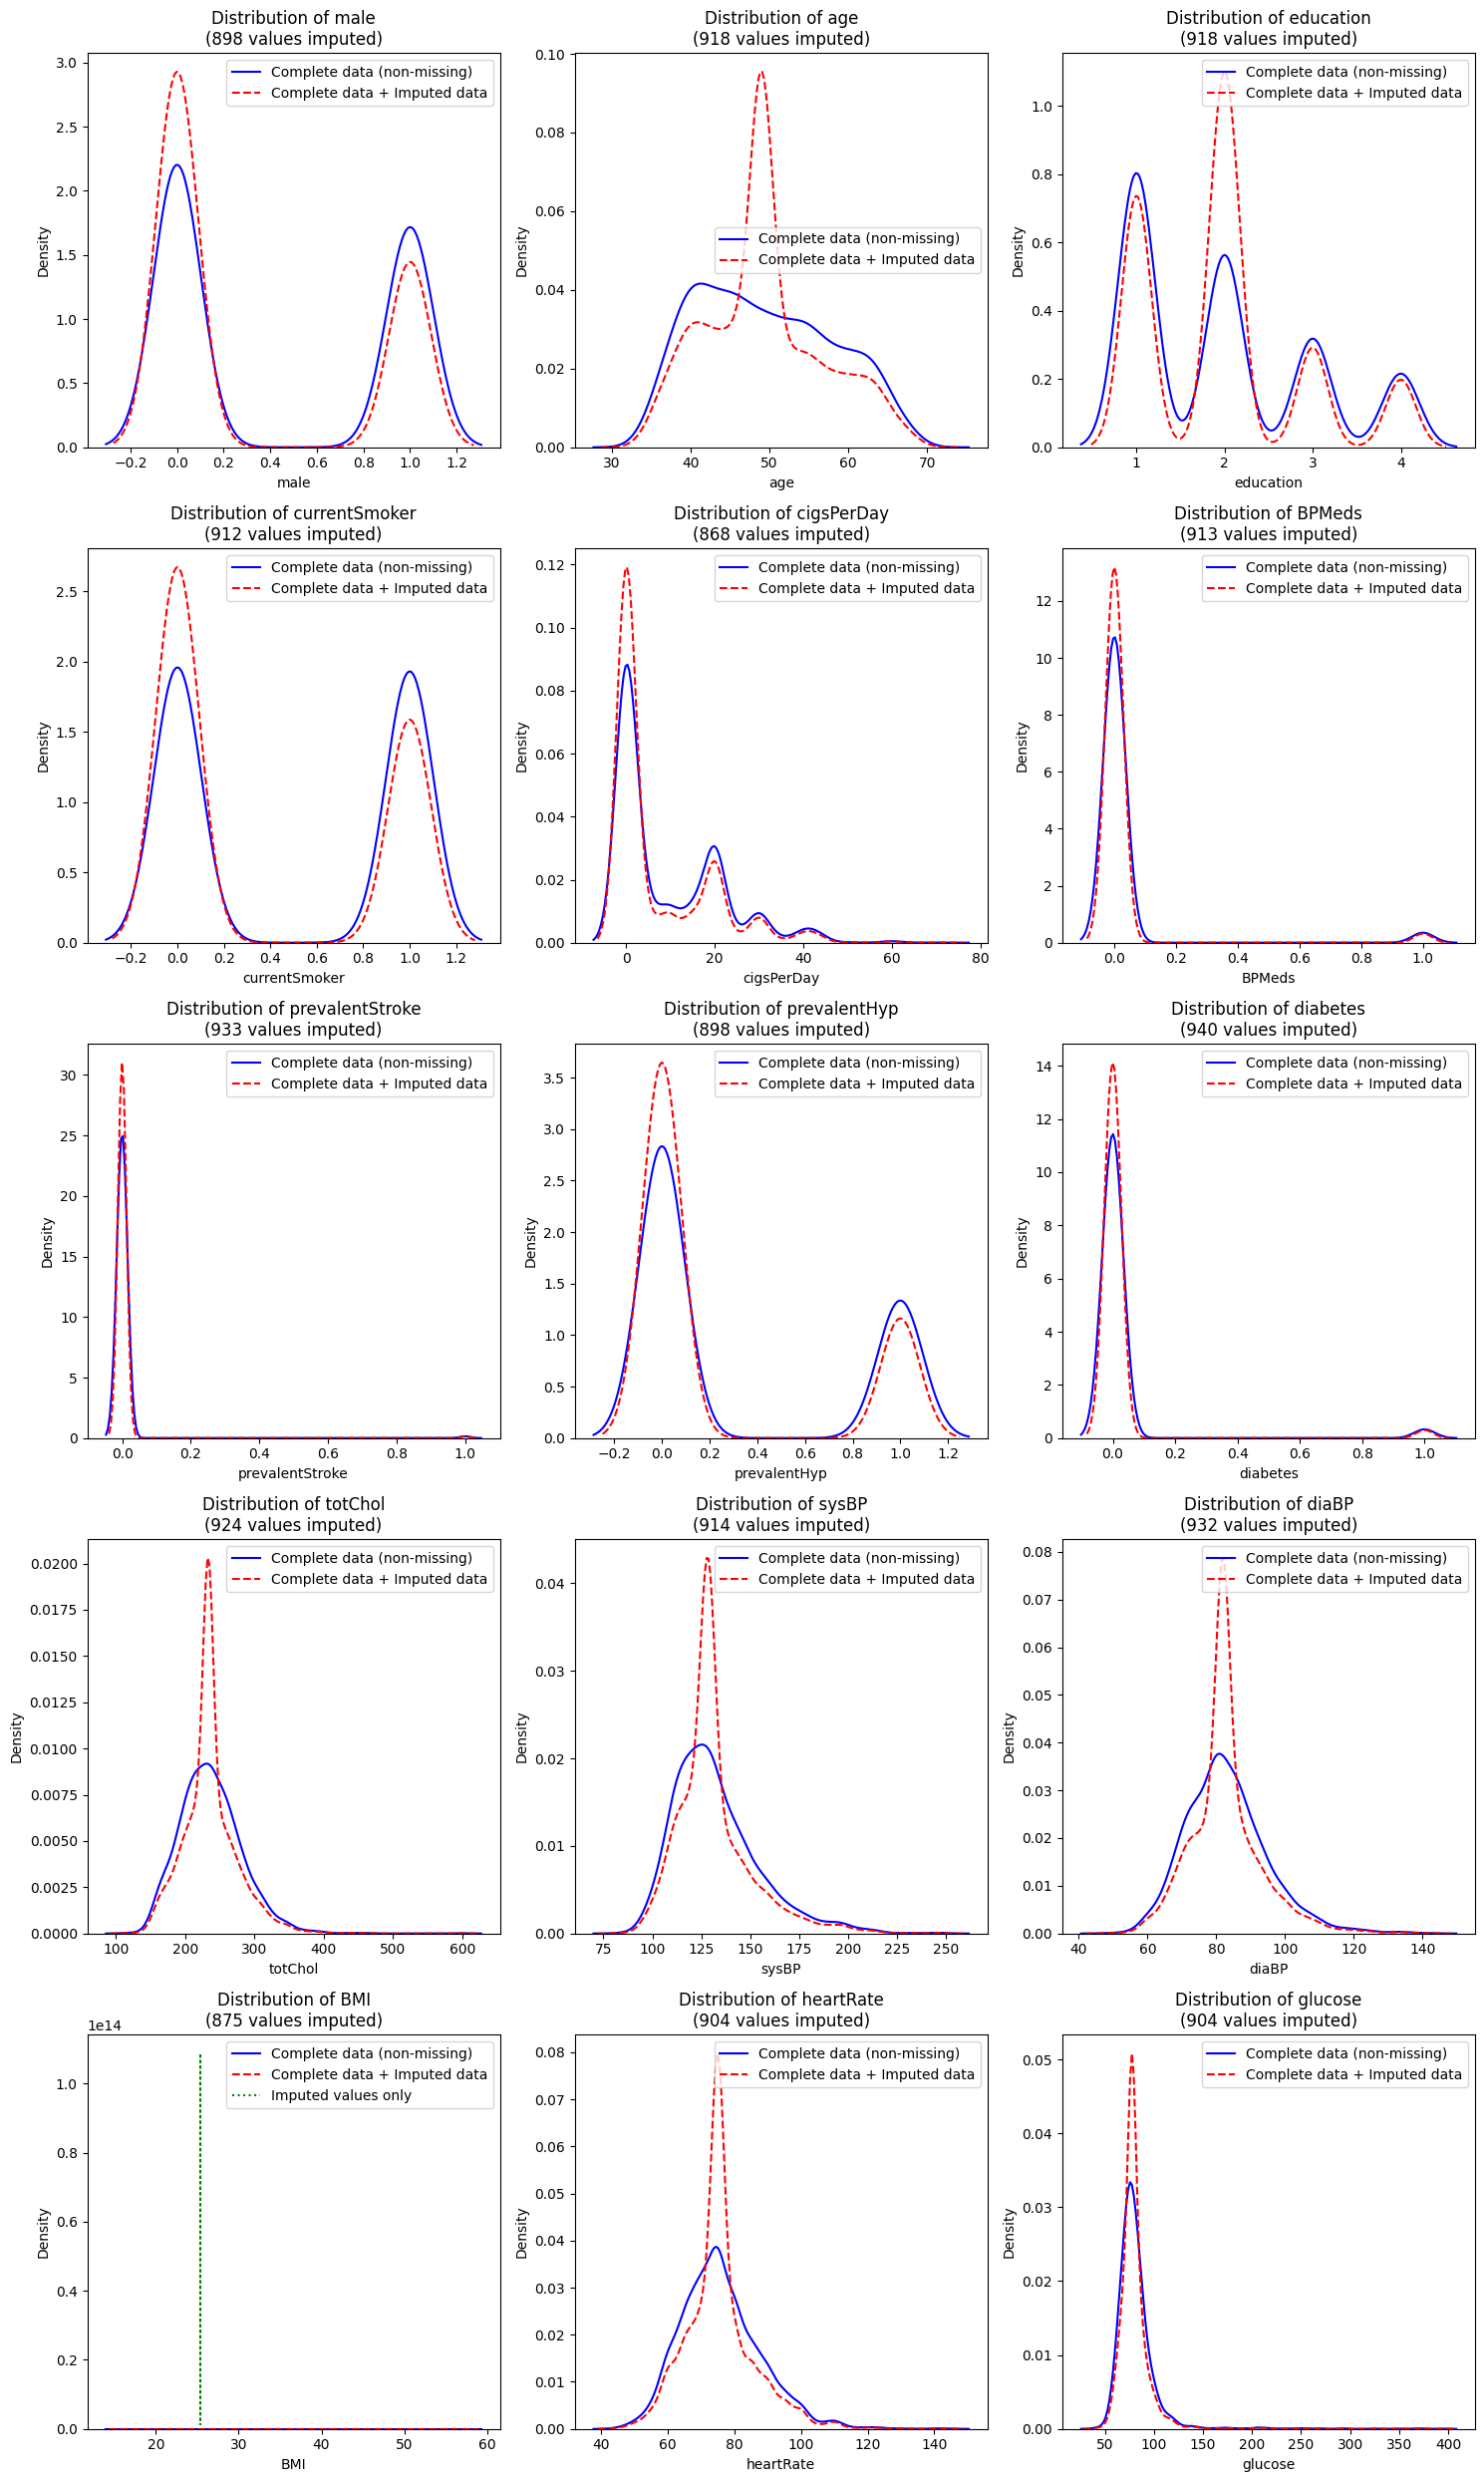

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Monticello_Saghafi_HonorsThesis/framingham.csv')
imputed_data = data_x.fillna(data_x.median())
imputed_data = pd.DataFrame(imputed_data, columns=data_x.columns)
print('medians', data_x.median())
print(imputed_data.isnull().sum())
plot_imputation_results(data_x, imputed_data)

medians male                 0.00
age                 49.00
education            2.00
currentSmoker        0.00
cigsPerDay           0.00
BPMeds               0.00
prevalentStroke      0.00
prevalentHyp         0.00
diabetes             0.00
totChol            233.00
sysBP              128.25
diaBP               82.00
BMI                 25.37
heartRate           75.00
glucose             78.00
dtype: float64
male               0
age                0
education          0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
dtype: int64


/tmp/ipython-input-2384667375.py:36: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
/tmp/ipython-input-2384667375.py:36: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
/tmp/ipython-input-2384667375.py:36: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
/tmp/ipython-input-2384667375.py:36: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
/tmp/ipython-input-2384667375.py:36: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
/tmp/ipython-input-2384667375.py:36: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
/tmp/ipython-input-2384667375.py:36: UserWarning: Dataset has 0 variance; skipping

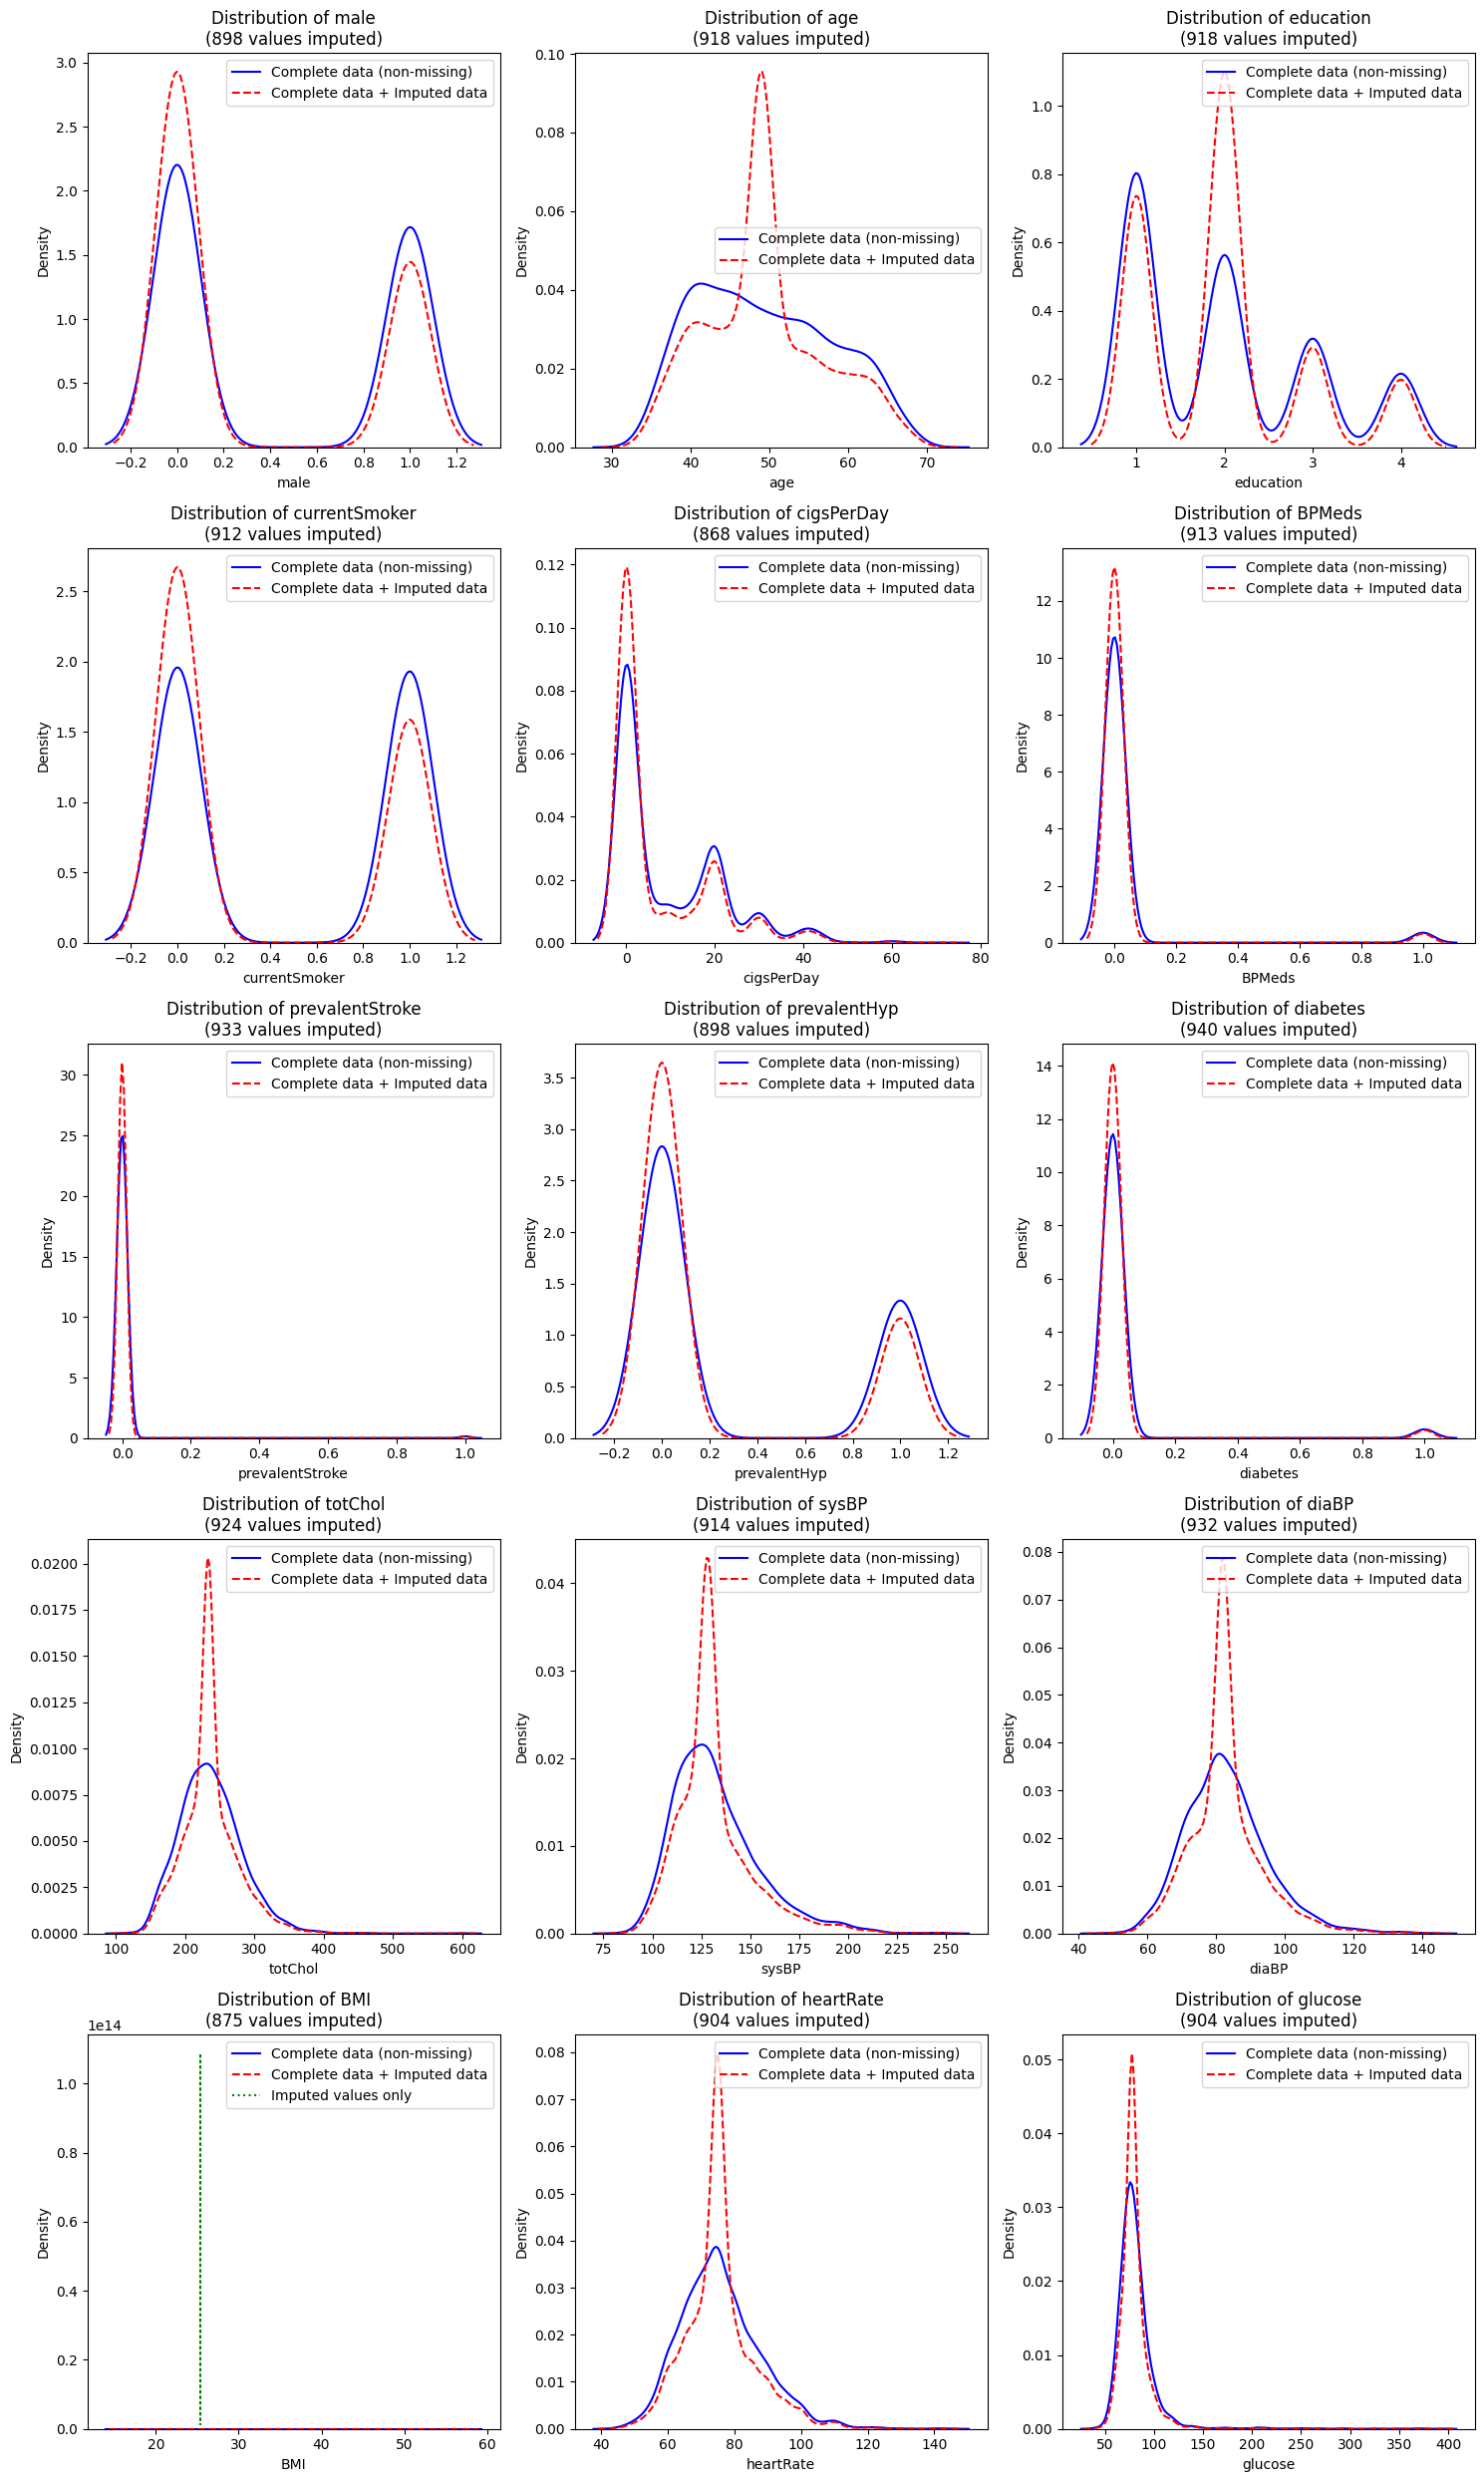


--- OVERALL RESULTS (MEDIAN) ---
Average NRMSE (Continuous): 1.0402
Overall PFC (Categorical): 0.2771
--------------------------------


Median Imputation Results Breakdown:



Type     RMSE   NRMSE     PFC  Imputed_Count
Variable                                                            
male             Categorical      NaN     NaN  0.4610            898
age               Continuous   8.5083  0.9937     NaN            918
education        Categorical      NaN     NaN  0.6852            918
currentSmoker    Categorical      NaN     NaN  0.4671            912
cigsPerDay        Continuous  14.4372  1.2110     NaN            868
BPMeds           Categorical      NaN     NaN  0.0263            913
prevalentStroke  Categorical      NaN     NaN  0.0054            933
prevalentHyp     Categorical      NaN     NaN  0.2851            898
diabetes         Categorical      NaN     NaN  0.0245            940
totChol           Continuous  42.3734  0.9609     NaN            924
sysBP             Continuous  22.6250  1.0244     NaN            914
diaBP             Continuous  12.1365  1.0136     NaN            932
BMI               Continuous   4.1200  1.0134     NaN            875
heartRate         Continuous  12.0766  1.0079     NaN            904
glucose           Continuous  26.2215  1.0969     NaN            904

In [ ]:
## MEDIAN IMPUTATION TEST RUN

# 1. Imputation (The variable remains 'imputed_data')
imputed_data = data_x.fillna(data_x.median())
imputed_data = pd.DataFrame(imputed_data, columns=data_x.columns)

# 2. CRUCIAL ADDITION: Save the unique result before the next method runs
IMPUTED_RESULTS['median'] = imputed_data.copy()

print('medians', data_x.median())
print(imputed_data.isnull().sum())

plot_imputation_results(data_x, imputed_data)

# Convert 'x' (numpy array) to DataFrame for evaluate_imputation function
x_df = pd.DataFrame(x, columns=df.columns[:-1])

# 3. NEW ADDITION: Run Evaluation and Display Table
median_results_table = evaluate_imputation(
    x_true=x_df, # Use the DataFrame version of 'x'
    x_missing=data_x,
    x_imputed=imputed_data,
    categorical_cols=IMPUTATION_CATEGORICAL_COLS
)

print("\nMedian Imputation Results Breakdown:\n")
display(median_results_table.round(4))

## MICE

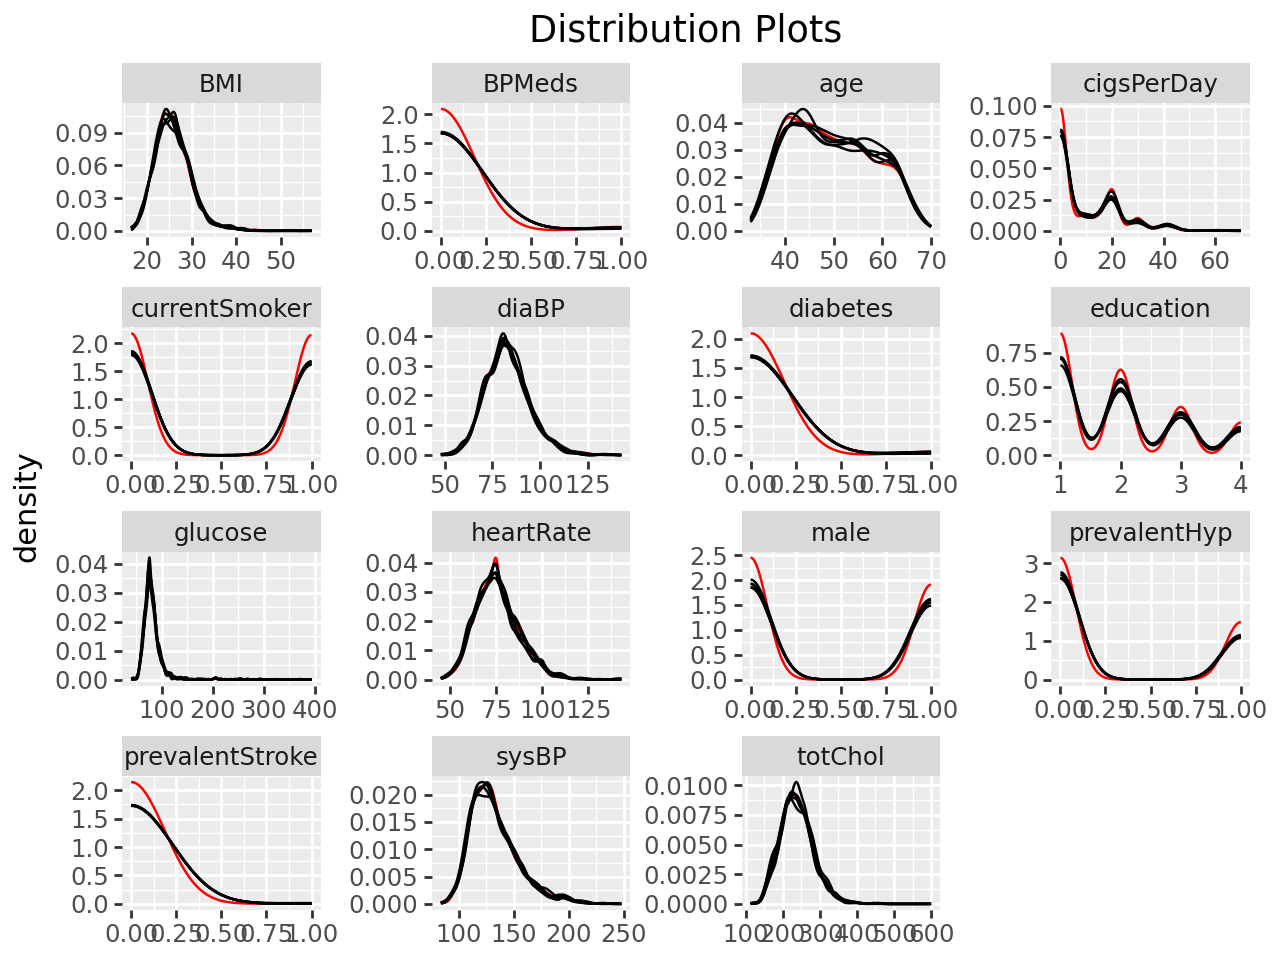

In [ ]:
## Test Run MiceForest
df = pd.read_csv('/content/drive/MyDrive/Monticello_Saghafi_HonorsThesis/framingham.csv')
import miceforest as mf_local # Re-import locally to ensure correct alias
kernel = mf_local.ImputationKernel(data_x, num_datasets=5, save_all_iterations_data=True, random_state=2026)
optimal_params = kernel.tune_parameters(dataset=0, use_gbdt=True, num_iterations=500, random_state=2026)
kernel.mice(1, variable_parameters=optimal_params)
imputed_data = kernel.complete_data(dataset=0)  # output is dataframe
kernel.plot_imputed_distributions()

[IterativeImputer] Completing matrix with shape (3658, 15)
[IterativeImputer] Change: 174.2720798036878, scaled tolerance: 0.060000000000000005 
[IterativeImputer] Change: 21.474438681228108, scaled tolerance: 0.060000000000000005 
[IterativeImputer] Change: 9.339596402468118, scaled tolerance: 0.060000000000000005 
[IterativeImputer] Change: 7.747822649315282, scaled tolerance: 0.060000000000000005 
[IterativeImputer] Change: 5.182632712444186, scaled tolerance: 0.060000000000000005 
[IterativeImputer] Change: 2.4353198982259974, scaled tolerance: 0.060000000000000005 
[IterativeImputer] Change: 2.283799085908015, scaled tolerance: 0.060000000000000005 
[IterativeImputer] Change: 1.7968271802467655, scaled tolerance: 0.060000000000000005 
[IterativeImputer] Change: 1.4783395801278991, scaled tolerance: 0.060000000000000005 
[IterativeImputer] Change: 1.6098891566396087, scaled tolerance: 0.060000000000000005 
[IterativeImputer] Change: 0.7286258002917453, scaled tolerance: 0.060000000

/usr/local/lib/python3.12/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.


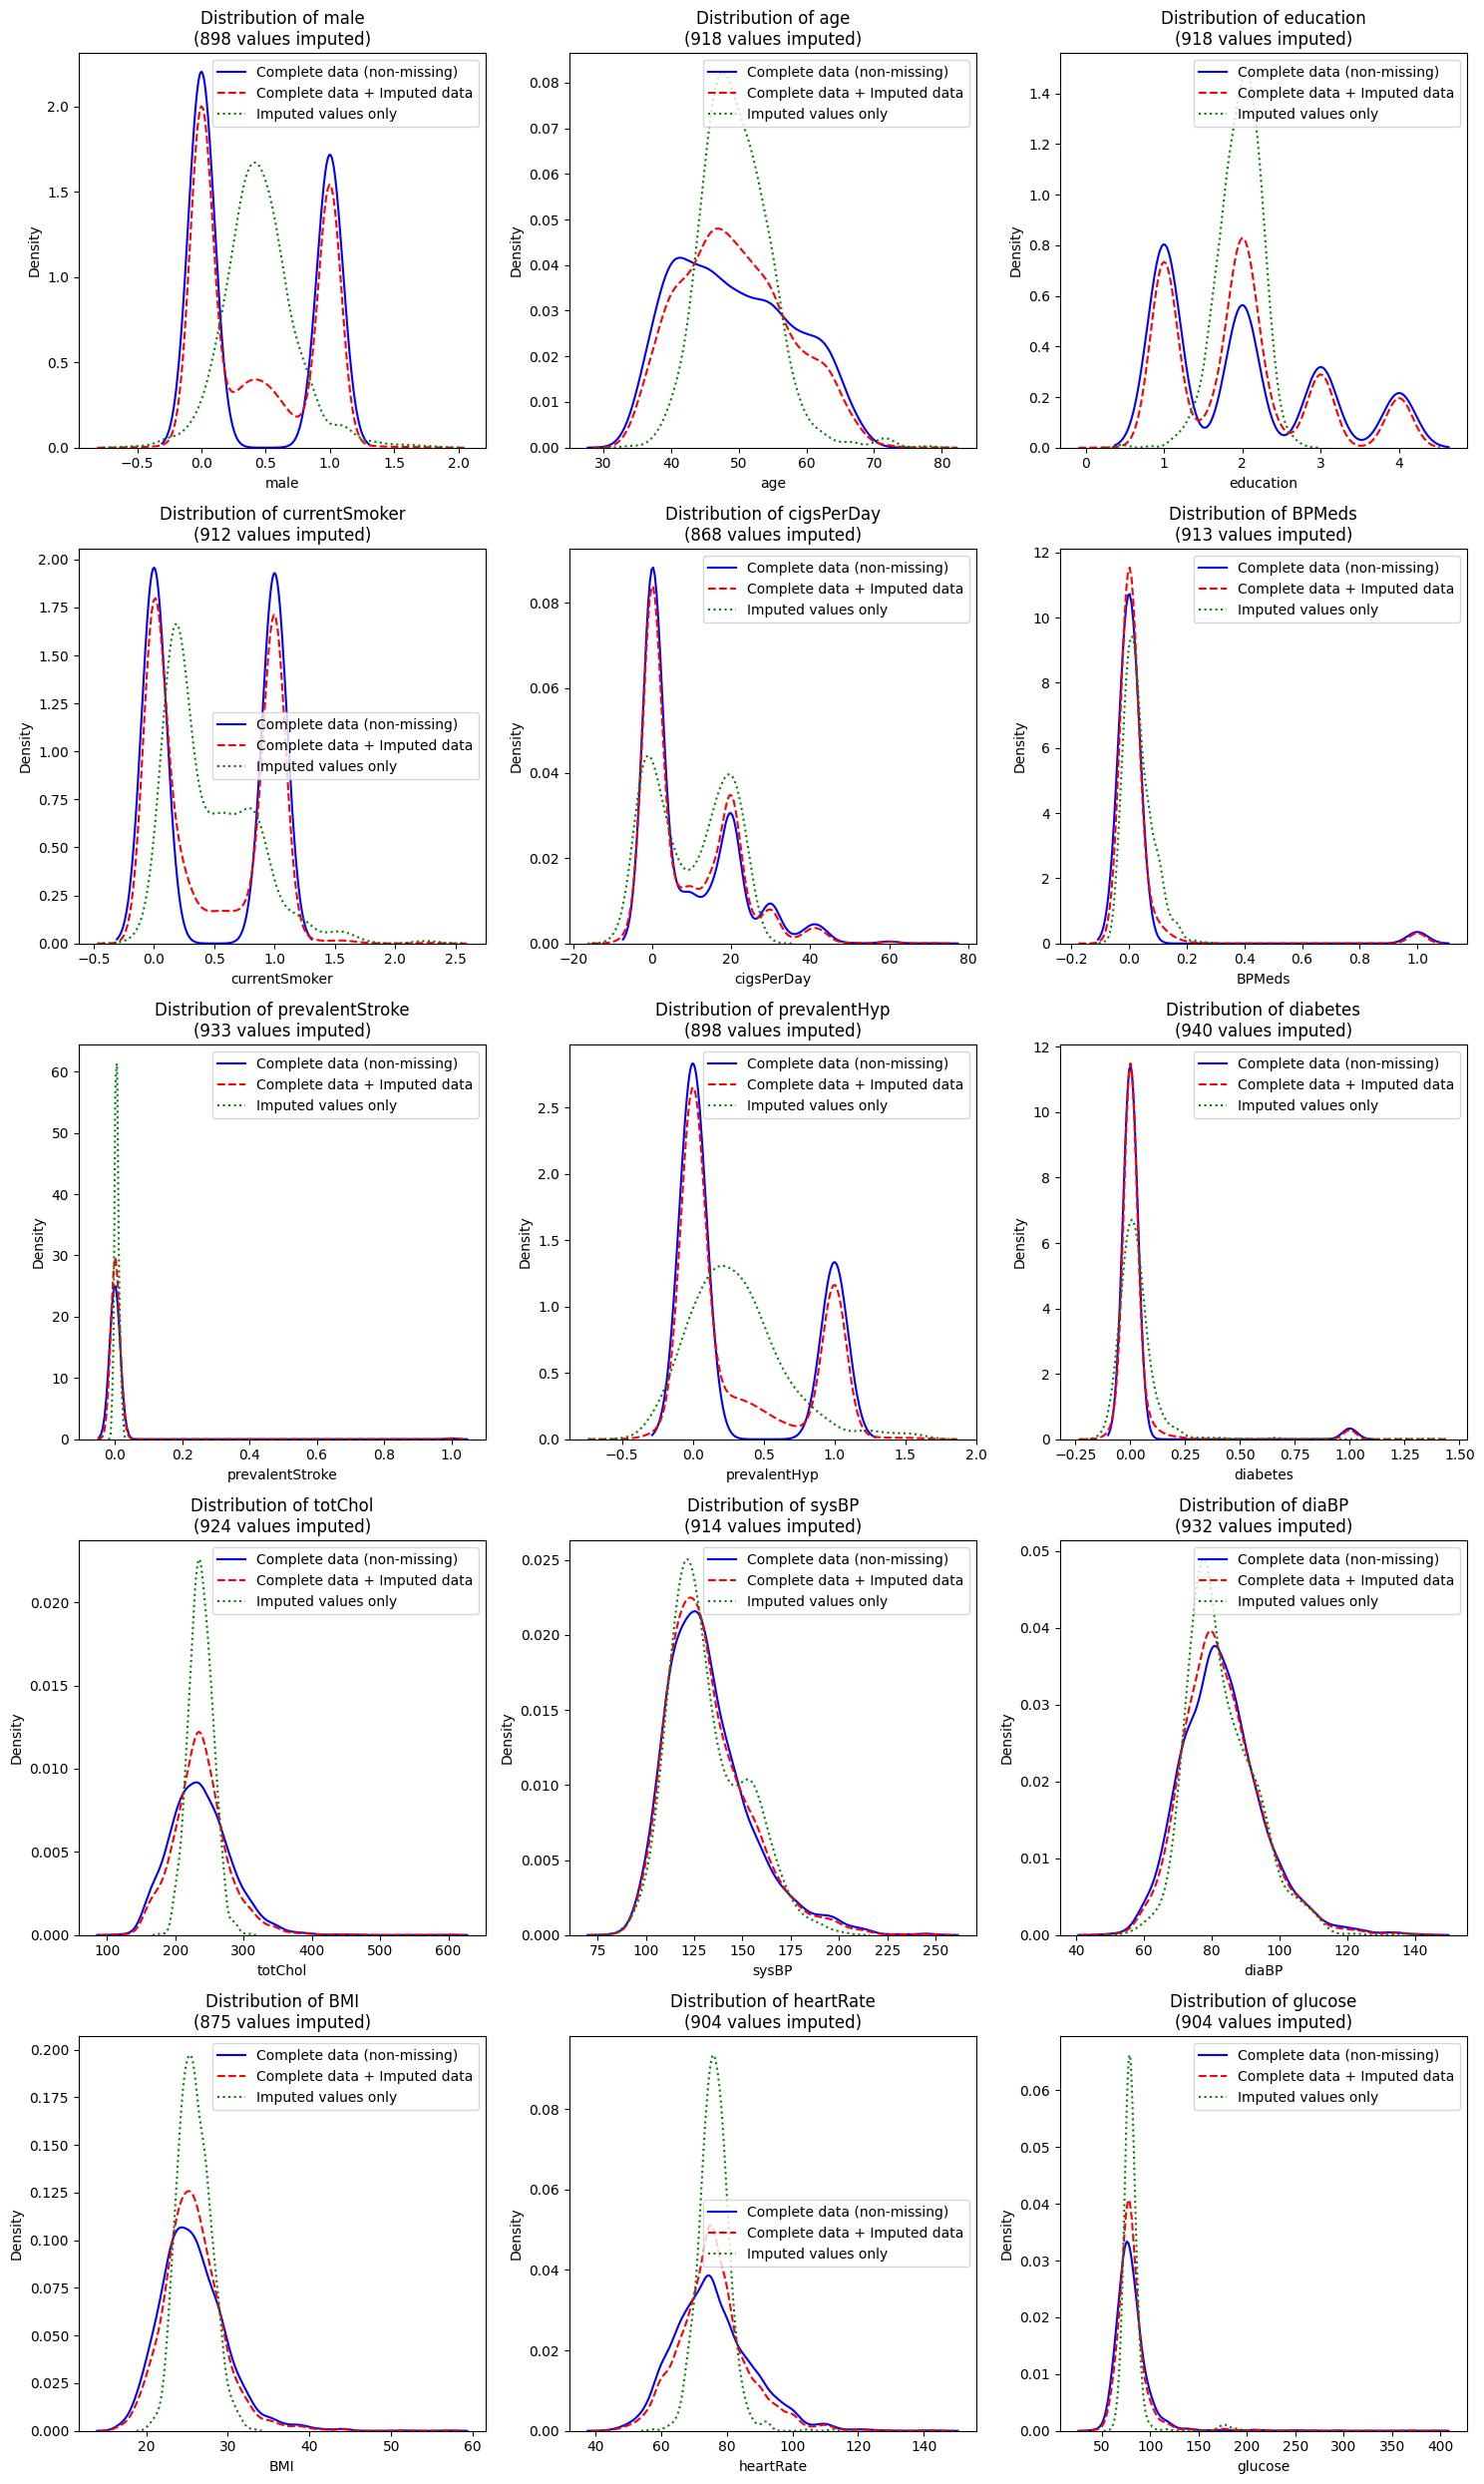

In [ ]:
## Test Run MICE using IterativeImputer
df = pd.read_csv('/content/drive/MyDrive/Monticello_Saghafi_HonorsThesis/framingham.csv')
mice = IterativeImputer(max_iter=20, initial_strategy='median', imputation_order='random', tol=1e-4, sample_posterior=False, verbose=1) #imputation_sequence_=[], random_state=2026
imputed_data = mice.fit_transform(data_x)
imputed_data = pd.DataFrame(imputed_data, columns=data_x.columns)
print(imputed_data.isnull().sum())
plot_imputation_results(data_x, imputed_data)

In [ ]:
print("--- Running MICE Imputation ---")

# Initialize and run the MICE Imputer
mice_imputer = IterativeImputer(
    max_iter=20,
    initial_strategy='median',
    imputation_order='random',
    random_state=2026,
    verbose=0
)

# Fit and Transform (returns a NumPy array)
imputed_data_np = mice_imputer.fit_transform(data_x)

# Convert NumPy array back to DataFrame (maintaining the generic name)
imputed_data = pd.DataFrame(imputed_data_np, columns=data_x.columns)

# ----------------------------------------------------
# REQUIRED ACTIONS
# ----------------------------------------------------
# 1. Save the unique result to the global dictionary
IMPUTED_RESULTS['mice'] = imputed_data.copy()

# 2. Run Evaluation and Display Table
mice_results_table = evaluate_imputation(
    x_true=x_df,
    x_missing=data_x,
    x_imputed=imputed_data,
    categorical_cols=IMPUTATION_CATEGORICAL_COLS
)

print("\nMICE Imputation Results Breakdown:\n")
display(mice_results_table.round(4))

--- Running MICE Imputation ---

--- OVERALL RESULTS (MEDIAN) ---
Average NRMSE (Continuous): 0.8376
Overall PFC (Categorical): 0.2453
--------------------------------


MICE Imputation Results Breakdown:



Type     RMSE   NRMSE     PFC  Imputed_Count
Variable                                                            
male             Categorical      NaN     NaN  0.4310            898
age               Continuous   7.7749  0.9081     NaN            918
education        Categorical      NaN     NaN  0.5926            918
currentSmoker    Categorical      NaN     NaN  0.3991            912
cigsPerDay        Continuous   8.5636  0.7183     NaN            868
BPMeds           Categorical      NaN     NaN  0.0263            913
prevalentStroke  Categorical      NaN     NaN  0.0054            933
prevalentHyp     Categorical      NaN     NaN  0.2539            898
diabetes         Categorical      NaN     NaN  0.0223            940
totChol           Continuous  41.0727  0.9314     NaN            924
sysBP             Continuous  12.7150  0.5757     NaN            914
diaBP             Continuous   7.9651  0.6652     NaN            932
BMI               Continuous   3.8061  0.9362     NaN            875
heartRate         Continuous  11.7849  0.9836     NaN            904
glucose           Continuous  23.4829  0.9824     NaN            904

## MissForest

/usr/local/lib/python3.12/dist-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
100%|██████████| 5/5 [00:19<00:00,  3.80s/it]
/usr/local/lib/python3.12/dist-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
/usr/local/lib/python3.12/dist-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
100%|██████████| 5/5 [00:01<00:00,  4.22it/s]


male               0
age                0
education          0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
dtype: int64


/tmp/ipython-input-2384667375.py:36: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
/tmp/ipython-input-2384667375.py:36: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
/tmp/ipython-input-2384667375.py:36: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
/tmp/ipython-input-2384667375.py:36: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.


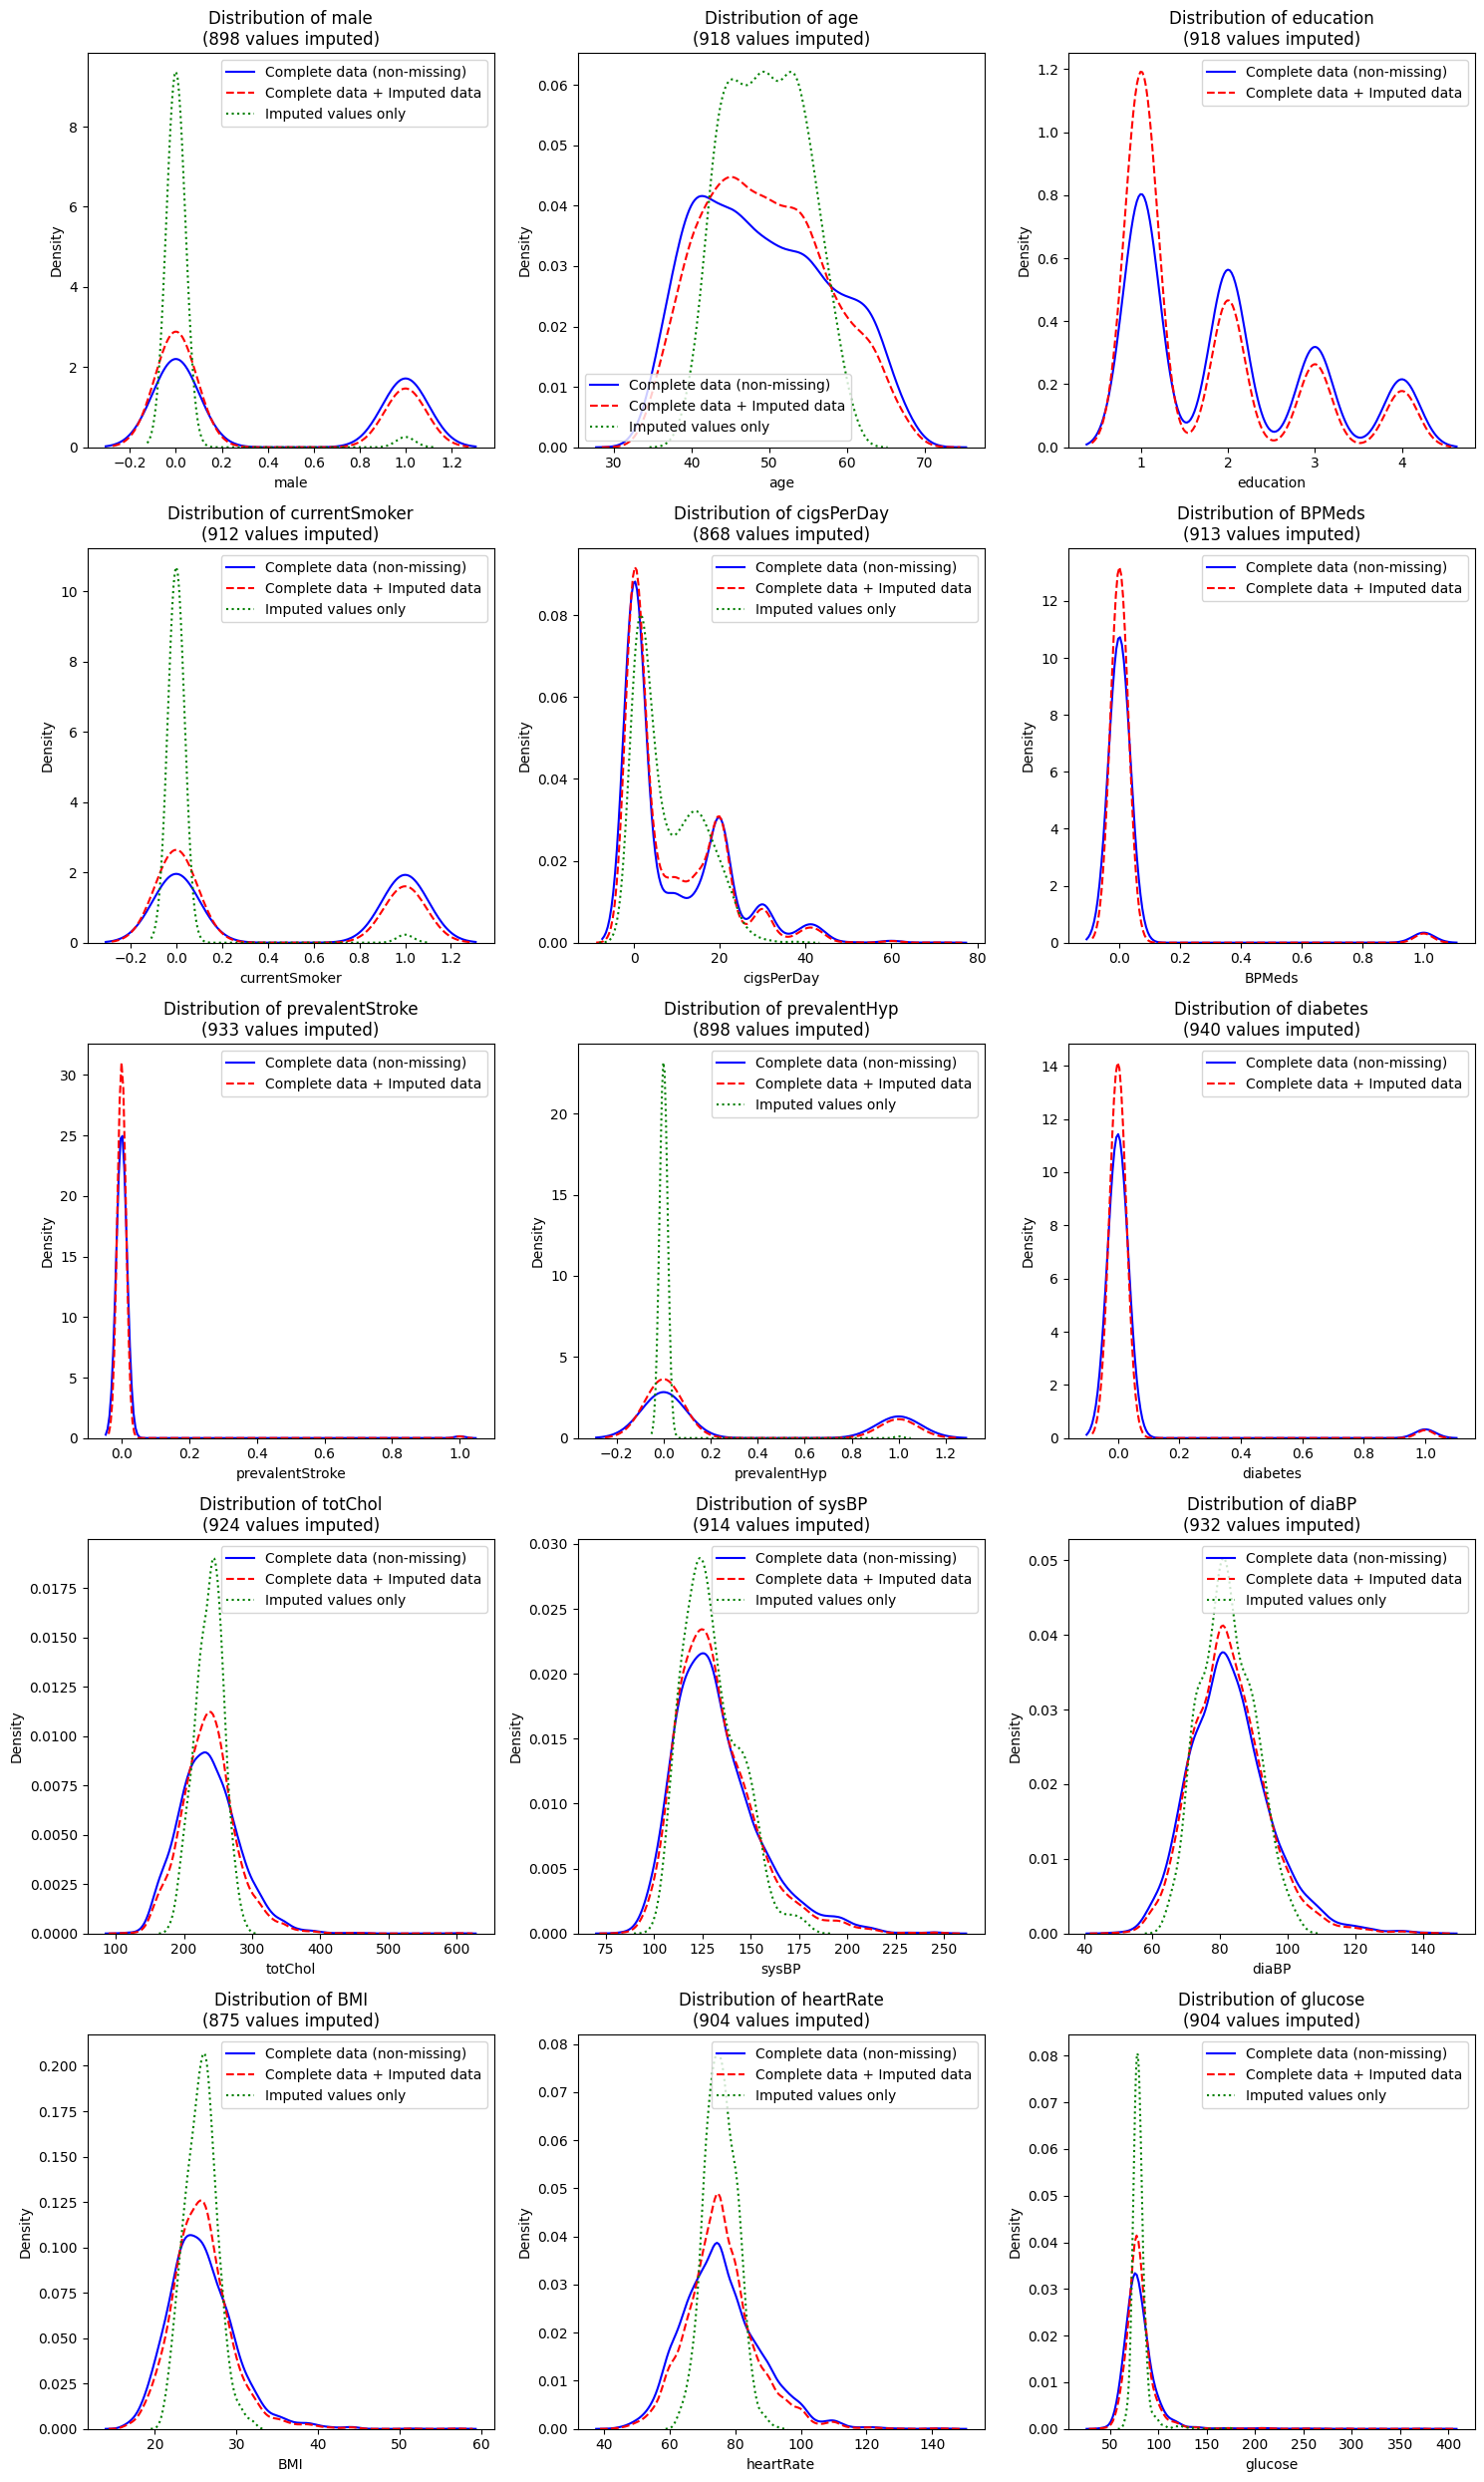

In [ ]:
## Test run MissForest
df = pd.read_csv('/content/drive/MyDrive/Monticello_Saghafi_HonorsThesis/framingham.csv')
categorical = ["male","currentSmoker", "education", "BPMeds", "prevalentStroke", "prevalentHyp", "diabetes"]
miss_forest_imputer = MissForest(categorical=categorical)
df_imputed = miss_forest_imputer.fit_transform(data_x)
df_imputed = pd.DataFrame(df_imputed, columns=data_x.columns)
print(df_imputed.isnull().sum())
plot_imputation_results(data_x, df_imputed)

In [ ]:
# Assuming MissForest is imported (e.g., from missingpy import MissForest)
import numpy as np
import pandas as pd

print("\n--- Running MissForest Imputation ---")

categorical_cols = ["male","currentSmoker", "education", "BPMeds", "prevalentStroke", "prevalentHyp", "diabetes"]
miss_forest_imputer = MissForest(
    categorical=categorical_cols,
    verbose=0
)

# Fit and Transform (returns a NumPy array)
imputed_data_np = miss_forest_imputer.fit_transform(data_x)

# Convert NumPy array back to DataFrame (maintaining the generic name)
imputed_data = pd.DataFrame(imputed_data_np, columns=data_x.columns)

# ----------------------------------------------------
# REQUIRED ACTIONS
# ----------------------------------------------------
# 1. Save the unique result to the global dictionary
IMPUTED_RESULTS['missforest'] = imputed_data.copy()

# 2. Run Evaluation and Display Table
missforest_results_table = evaluate_imputation(
    x_true=x_df,
    x_missing=data_x,
    x_imputed=imputed_data,
    categorical_cols=IMPUTATION_CATEGORICAL_COLS
)

print("\nMissForest Imputation Results Breakdown:\n")
display(missforest_results_table.round(4))


--- Running MissForest Imputation ---

--- OVERALL RESULTS (MEDIAN) ---
Average NRMSE (Continuous): 0.8844
Overall PFC (Categorical): 0.2587
--------------------------------


MissForest Imputation Results Breakdown:



Type     RMSE   NRMSE     PFC  Imputed_Count
Variable                                                            
male             Categorical      NaN     NaN  0.4410            898
age               Continuous   7.8908  0.9216     NaN            918
education        Categorical      NaN     NaN  0.5991            918
currentSmoker    Categorical      NaN     NaN  0.4463            912
cigsPerDay        Continuous   9.1175  0.7648     NaN            868
BPMeds           Categorical      NaN     NaN  0.0263            913
prevalentStroke  Categorical      NaN     NaN  0.0054            933
prevalentHyp     Categorical      NaN     NaN  0.2829            898
diabetes         Categorical      NaN     NaN  0.0245            940
totChol           Continuous  42.6787  0.9678     NaN            924
sysBP             Continuous  14.2808  0.6466     NaN            914
diaBP             Continuous   8.7477  0.7305     NaN            932
BMI               Continuous   3.9738  0.9774     NaN            875
heartRate         Continuous  12.2496  1.0224     NaN            904
glucose           Continuous  24.9609  1.0442     NaN            904

## GAIN

In [ ]:
## Necessary packages
##---------------------
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

## All Functions TF2
##-------------------

'''Utility functions for gain.
(3) normalization: Mixe OneHotEncoded nan columns with the encoded data.
(4) renormalization: Plot the loss functions over iterations.
(5) xavier_init: Round imputed data based on input data decimals.
(6) rounding: Round imputed data based on input data decimals.
(7) binary_sampler: Enhanced GAIN to impute missing values in data_x.
(8) uniform_sampler: Enhanced GAIN to impute missing values in data_x.
(9) sample_batch_index: Enhanced GAIN to impute missing values in data_x.
(10) gain: GAIN to impute missing values in data_x.
'''

def normalization (data, parameters=None):
  '''Normalize data in [0, 1] range.'''
  # Parameters
  _, dim = data.shape
  norm_data = data.copy()

  if parameters is None:
    # MixMax normalization
    min_val = np.zeros(dim)
    max_val = np.zeros(dim)
    # For each dimension
    for i in range(dim):
      min_val[i] = np.nanmin(norm_data[:,i])
      norm_data[:,i] = norm_data[:,i] - np.nanmin(norm_data[:,i])
      max_val[i] = np.nanmax(norm_data[:,i])
      norm_data[:,i] = norm_data[:,i] / (np.nanmax(norm_data[:,i]) + 1e-6)
    # Return norm_parameters for renormalization
    norm_parameters = {'min_val': min_val,
                       'max_val': max_val}
  else:
    min_val = parameters['min_val']
    max_val = parameters['max_val']
    # For each dimension
    for i in range(dim):
      norm_data[:,i] = norm_data[:,i] - min_val[i]
      norm_data[:,i] = norm_data[:,i] / (max_val[i] + 1e-6)

    norm_parameters = parameters

  return norm_data, norm_parameters


def renormalization (norm_data, norm_parameters):
  '''Renormalize data from [0, 1] range to the original range.'''
  min_val = norm_parameters['min_val']
  max_val = norm_parameters['max_val']

  _, dim = norm_data.shape
  renorm_data = norm_data.copy()

  for i in range(dim):
    renorm_data[:,i] = renorm_data[:,i] * (max_val[i] + 1e-6)
    renorm_data[:,i] = renorm_data[:,i] + min_val[i]

  return renorm_data


def xavier_init(size):
  '''Xavier initialization.'''
  in_dim = size[0]
  xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
  return tf.random_normal(shape = size, stddev = xavier_stddev)


def rounding (imputed_data, data_x):
  '''Round imputed data for categorical variables.'''
  _, dim = data_x.shape
  rounded_data = imputed_data.copy()
  for i in range(dim):
    temp = data_x[~np.isnan(data_x[:, i]), i]
    # Only for the categorical variable
    if len(np.unique(temp)) < 20:
      rounded_data[:, i] = np.round(rounded_data[:, i])

  return rounded_data


def binary_sampler(p, rows, cols):
  '''generates binary random matrix.'''
  unif_random_matrix = np.random.uniform(0., 1., size = [rows, cols])
  binary_random_matrix = 1*(unif_random_matrix < p)
  return binary_random_matrix


def uniform_sampler(low, high, rows, cols):
  '''generates uniform random matrix.'''
  return np.random.uniform(low, high, size = [rows, cols])


def sample_batch_index(total, batch_size):
  '''Sample index of the mini-batch. '''
  total_idx = np.random.permutation(total)
  batch_idx = total_idx[:batch_size]
  return batch_idx


def gain (data_x, gain_parameters):
  '''Imputes missing values in data_x.
  data_x: input data with missing values
  gain_parameters: input dictionary of EGAIN parameters
  '''
  # System params
  batch_size = gain_parameters['batch_size']
  hint_rate = gain_parameters['hint_rate']
  alpha = gain_parameters['alpha']
  iterations = gain_parameters['iterations']

  # Other params
  no, dim = data_x.shape
  h_dim = int(dim)

  # Mask matrix
  data_m = 1 - np.isnan(data_x)

  # Normalization
  norm_data, norm_parameters = normalization(data_x)
  norm_data_x = np.nan_to_num(norm_data, 0)

  ## GAIN architecture
  ##--------------------
  # Define Generator Model
  def build_generator():
    x_input = Input(shape=(dim * 2,))
    h1 = Dense(h_dim, activation='relu', kernel_initializer='glorot_normal')(x_input)
    h2 = Dense(h_dim, activation='relu', kernel_initializer='glorot_normal')(h1)
    output = Dense(dim, activation='sigmoid')(h2)
    return Model(x_input, output)

  # Define Discriminator Model
  def build_discriminator():
    x_input = Input(shape=(dim * 2,))
    h1 = Dense(h_dim, activation='relu', kernel_initializer='glorot_normal')(x_input)
    h2 = Dense(h_dim, activation='relu', kernel_initializer='glorot_normal')(h1)
    output = Dense(dim, activation='sigmoid')(h2)
    return Model(x_input, output)

  generator = build_generator()
  discriminator = build_discriminator()

  ## GAIN structure
  ##--------------------
  @tf.function
  def train_step(X_mb, M_mb, H_mb):
    # Convert to float tensors
    X_mb = tf.cast(X_mb, tf.float32)
    M_mb = tf.cast(M_mb, tf.float32)
    H_mb = tf.cast(H_mb, tf.float32)
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generator
        G_sample = generator(tf.concat([X_mb, M_mb], axis=1))
        # Combine with observed data
        Hat_X = (M_mb * X_mb) + ((1 - M_mb) * G_sample)
        # Discriminator
        D_prob = discriminator(tf.concat([Hat_X, H_mb], axis=1))
        ## GAIN loss
        D_loss = -tf.reduce_mean(M_mb * tf.math.log(D_prob + 1e-8) + (1 - M_mb) * tf.math.log(1. - D_prob + 1e-8))
        G_loss_temp = -tf.reduce_mean((1 - M_mb) * tf.math.log(D_prob + 1e-8))
        MSE_loss = tf.reduce_mean(tf.square(M_mb * X_mb - M_mb * G_sample))
        G_loss = G_loss_temp + (alpha * MSE_loss)

    gradients_of_discriminator = disc_tape.gradient(D_loss, discriminator.trainable_variables)
    gradients_of_generator = gen_tape.gradient(G_loss, generator.trainable_variables)

    optimizer_D.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    optimizer_G.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    return D_loss, G_loss_temp, MSE_loss, G_loss

  optimizer_D = tf.keras.optimizers.Adam()
  optimizer_G = tf.keras.optimizers.Adam()

  ## Iterations
  ##--------------------
  # Initialize
  for it in tqdm(range(iterations)):
    # Sample batch
    batch_idx = sample_batch_index(no, batch_size)
    X_mb = norm_data_x[batch_idx, :]
    M_mb = data_m[batch_idx, :]
    # Sample random noise
    Z_mb = uniform_sampler(0, 0.01, batch_size, dim)
    # Combine random noise with observed vectors
    X_mb = (M_mb * X_mb) + ((1 - M_mb) * Z_mb)
    # Sample hint vectors
    B_mb = binary_sampler(hint_rate, batch_size, dim)
    H_mb = (B_mb * M_mb)
    # Calculate loss
    D_loss_curr, Gt_loss_curr, MSE_loss_curr, G_loss_curr = train_step(X_mb, M_mb, H_mb)

  ## Final Imputation
  ##--------------------
  X_mb = norm_data_x
  M_mb = data_m
  Z_mb = uniform_sampler(0, 0.01, no, dim)
  X_mb = (M_mb * X_mb) + ((1 - M_mb) * Z_mb)

  ## Return imputed data
  imputed_data = generator(tf.concat([X_mb, M_mb], axis=1)).numpy()
  imputed_data = (data_m * norm_data_x) + ((1 - data_m) * imputed_data)

  # Renormalization
  imputed_data = renormalization(imputed_data, norm_parameters)

  # Rounding
  imputed_data = rounding(imputed_data, data_x)

  return imputed_data

100%|██████████| 1200/1200 [00:03<00:00, 307.29it/s]


male               0
age                0
education          0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
dtype: int64


/tmp/ipython-input-2384667375.py:36: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
/tmp/ipython-input-2384667375.py:36: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.


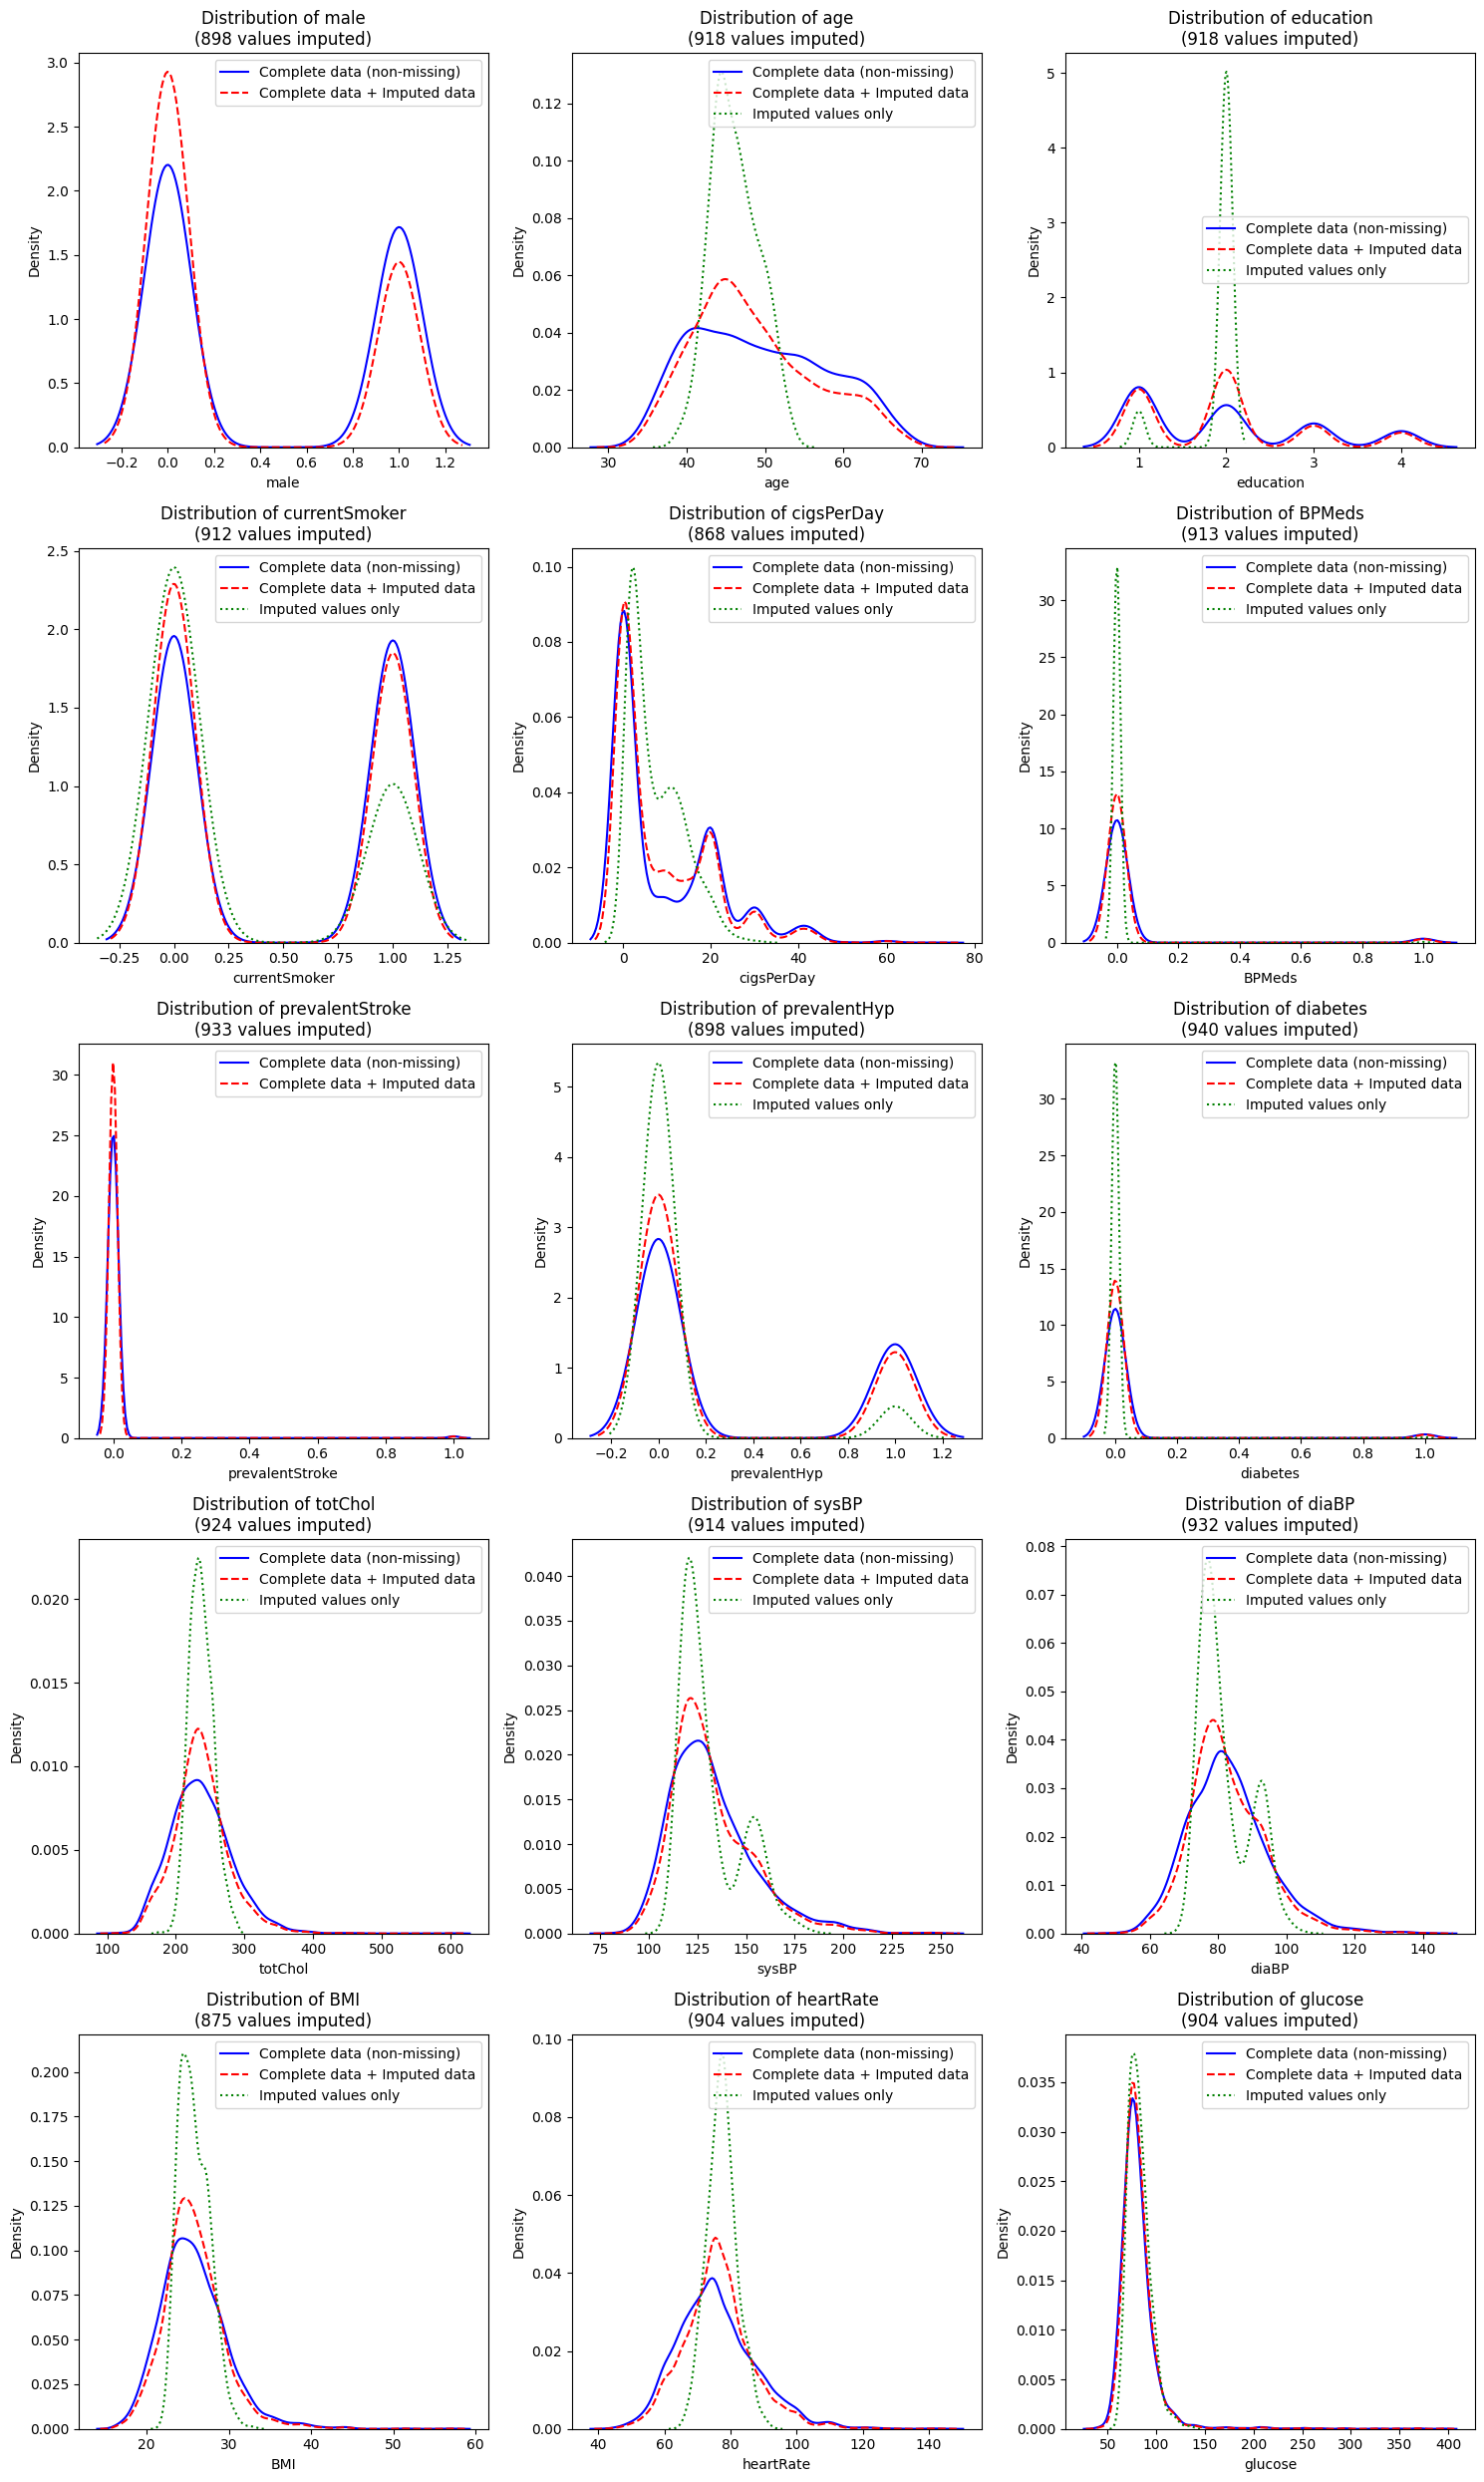

In [ ]:
## Test run
df = pd.read_csv('/content/drive/MyDrive/Monticello_Saghafi_HonorsThesis/framingham.csv')
dff = pd.read_csv('/content/drive/MyDrive/Monticello_Saghafi_HonorsThesis/framingham.csv').to_numpy(dtype=float)
data_x_np = data_x.to_numpy(dtype=float)
gain_parameters = {'batch_size': 64, 'hint_rate': 0.90, 'alpha': 60, 'iterations': 1200}
tf.keras.backend.clear_session()
df_imputed = gain(data_x_np, gain_parameters)
df_imputed = pd.DataFrame(df_imputed, columns=data_x.columns)
print(df_imputed.isnull().sum())
plot_imputation_results(data_x, df_imputed)

In [ ]:
import numpy as np
import pandas as pd

# NOTE: Ensure your data_x is fully numerical and scaled for GAIN!
print("\n--- Running GAIN Imputation ---")

# Define GAIN parameters (adjust iterations/alpha as needed)
gain_parameters = {'batch_size': 64, 'hint_rate': 0.90, 'alpha': 60, 'iterations': 1200}

# Convert DataFrame to NumPy array for the GAIN function input
data_x_np = data_x.to_numpy(dtype=float)

# Run the GAIN function
imputed_data_np = gain(data_x_np, gain_parameters)

# Convert NumPy array back to DataFrame (maintaining the generic name)
imputed_data = pd.DataFrame(imputed_data_np, columns=data_x.columns)

# ----------------------------------------------------
# REQUIRED ACTIONS
# ----------------------------------------------------
# 1. Save the unique result to the global dictionary
IMPUTED_RESULTS['gain'] = imputed_data.copy()

# Convert 'x' (numpy array) to DataFrame for evaluate_imputation function
x_df = pd.DataFrame(x, columns=df.columns[:-1])

# 2. Run Evaluation and Display Table
gain_results_table = evaluate_imputation(
    x_true=x_df,
    x_missing=data_x,
    x_imputed=imputed_data,
    categorical_cols=IMPUTATION_CATEGORICAL_COLS
)

print("\nGAIN Imputation Results Breakdown:\n")
display(gain_results_table.round(4))


--- Running GAIN Imputation ---


100%|██████████| 1200/1200 [00:03<00:00, 319.07it/s]


--- OVERALL RESULTS (MEDIAN) ---
Average NRMSE (Continuous): 0.9429
Overall PFC (Categorical): 0.2375
--------------------------------


GAIN Imputation Results Breakdown:



Type     RMSE   NRMSE     PFC  Imputed_Count
Variable                                                            
male             Categorical      NaN     NaN  0.4543            898
age               Continuous   8.6115  1.0058     NaN            918
education        Categorical      NaN     NaN  0.6460            918
currentSmoker    Categorical      NaN     NaN  0.2621            912
cigsPerDay        Continuous   8.4732  0.7107     NaN            868
BPMeds           Categorical      NaN     NaN  0.0263            913
prevalentStroke  Categorical      NaN     NaN  0.0054            933
prevalentHyp     Categorical      NaN     NaN  0.2572            898
diabetes         Categorical      NaN     NaN  0.0245            940
totChol           Continuous  44.7983  1.0159     NaN            924
sysBP             Continuous  16.0977  0.7288     NaN            914
diaBP             Continuous   9.8345  0.8213     NaN            932
BMI               Continuous   4.2124  1.0361     NaN            875
heartRate         Continuous  12.4262  1.0371     NaN            904
glucose           Continuous  28.3780  1.1872     NaN            904

## EGAIN

In [ ]:
!pip install EGAIN

In [ ]:
## Test run EGAIN
from EGAIN import EGAIN # Import the EGAIN function/class

df = pd.read_csv('/content/drive/MyDrive/Monticello_Saghafi_HonorsThesis/framingham.csv').to_numpy(dtype=float)
egain_parameters = {'batch_size': 64, 'hint_rate': 0.90, 'alpha': 60, 'iterations': 2000}
df_imputed = EGAIN(data_x, egain_parameters, retrain=False, plots=True)
df_imputed = pd.DataFrame(df_imputed, columns=data_x.columns)
print(df_imputed.isnull().sum())
plot_imputation_results(data_x, df_imputed)

  0%|          | 0/2000 [00:00<?, ?it/s]


InvalidIndexError: (array([ 947, 1237, 1465, 2651, 2786,  648, 2996,  362,  160, 2647, 3541,
       1056, 1686, 2719, 2810, 1892, 1850, 2234, 3052,  664,  885, 3583,
         79, 2535, 3288, 2694, 3415, 1286, 2186,   55, 2099,  327,  341,
       2849, 3122,  998, 1402,  786, 2047, 2148,  830,  715, 2860,  391,
        501, 2170, 1672, 2188, 2240,   32, 3139, 3115,  707, 1840, 1546,
       1909,  796,  845, 3476, 2887, 2600, 3244,  692, 2151]), slice(None, None, None))

100%|██████████| 2000/2000 [00:30<00:00, 65.94it/s] 


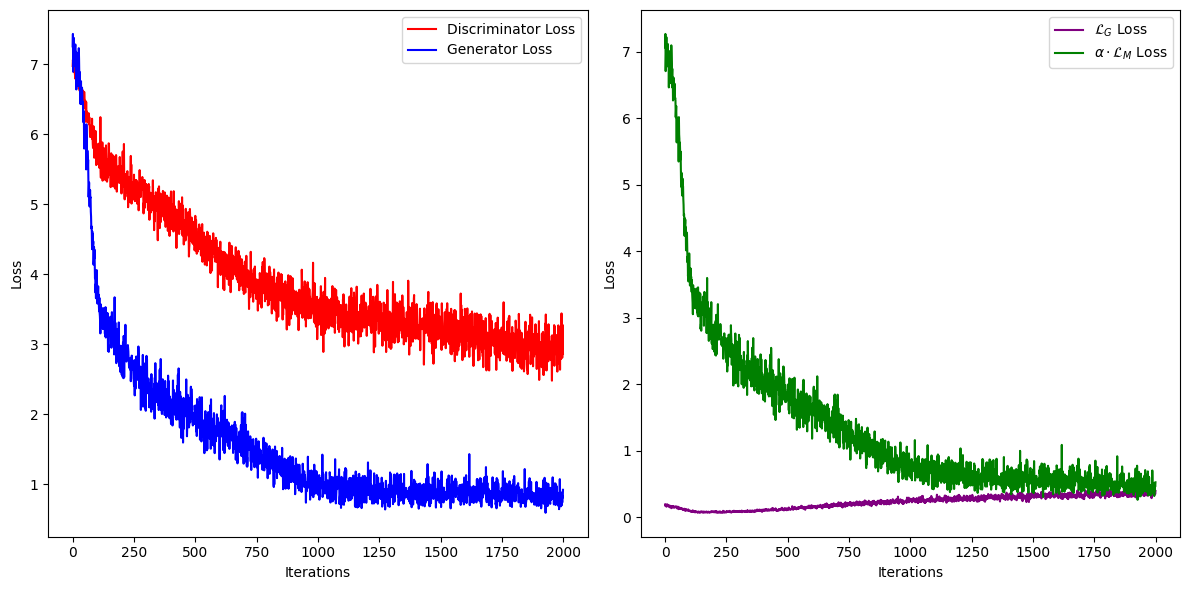

male               0
age                0
education          0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
dtype: int64


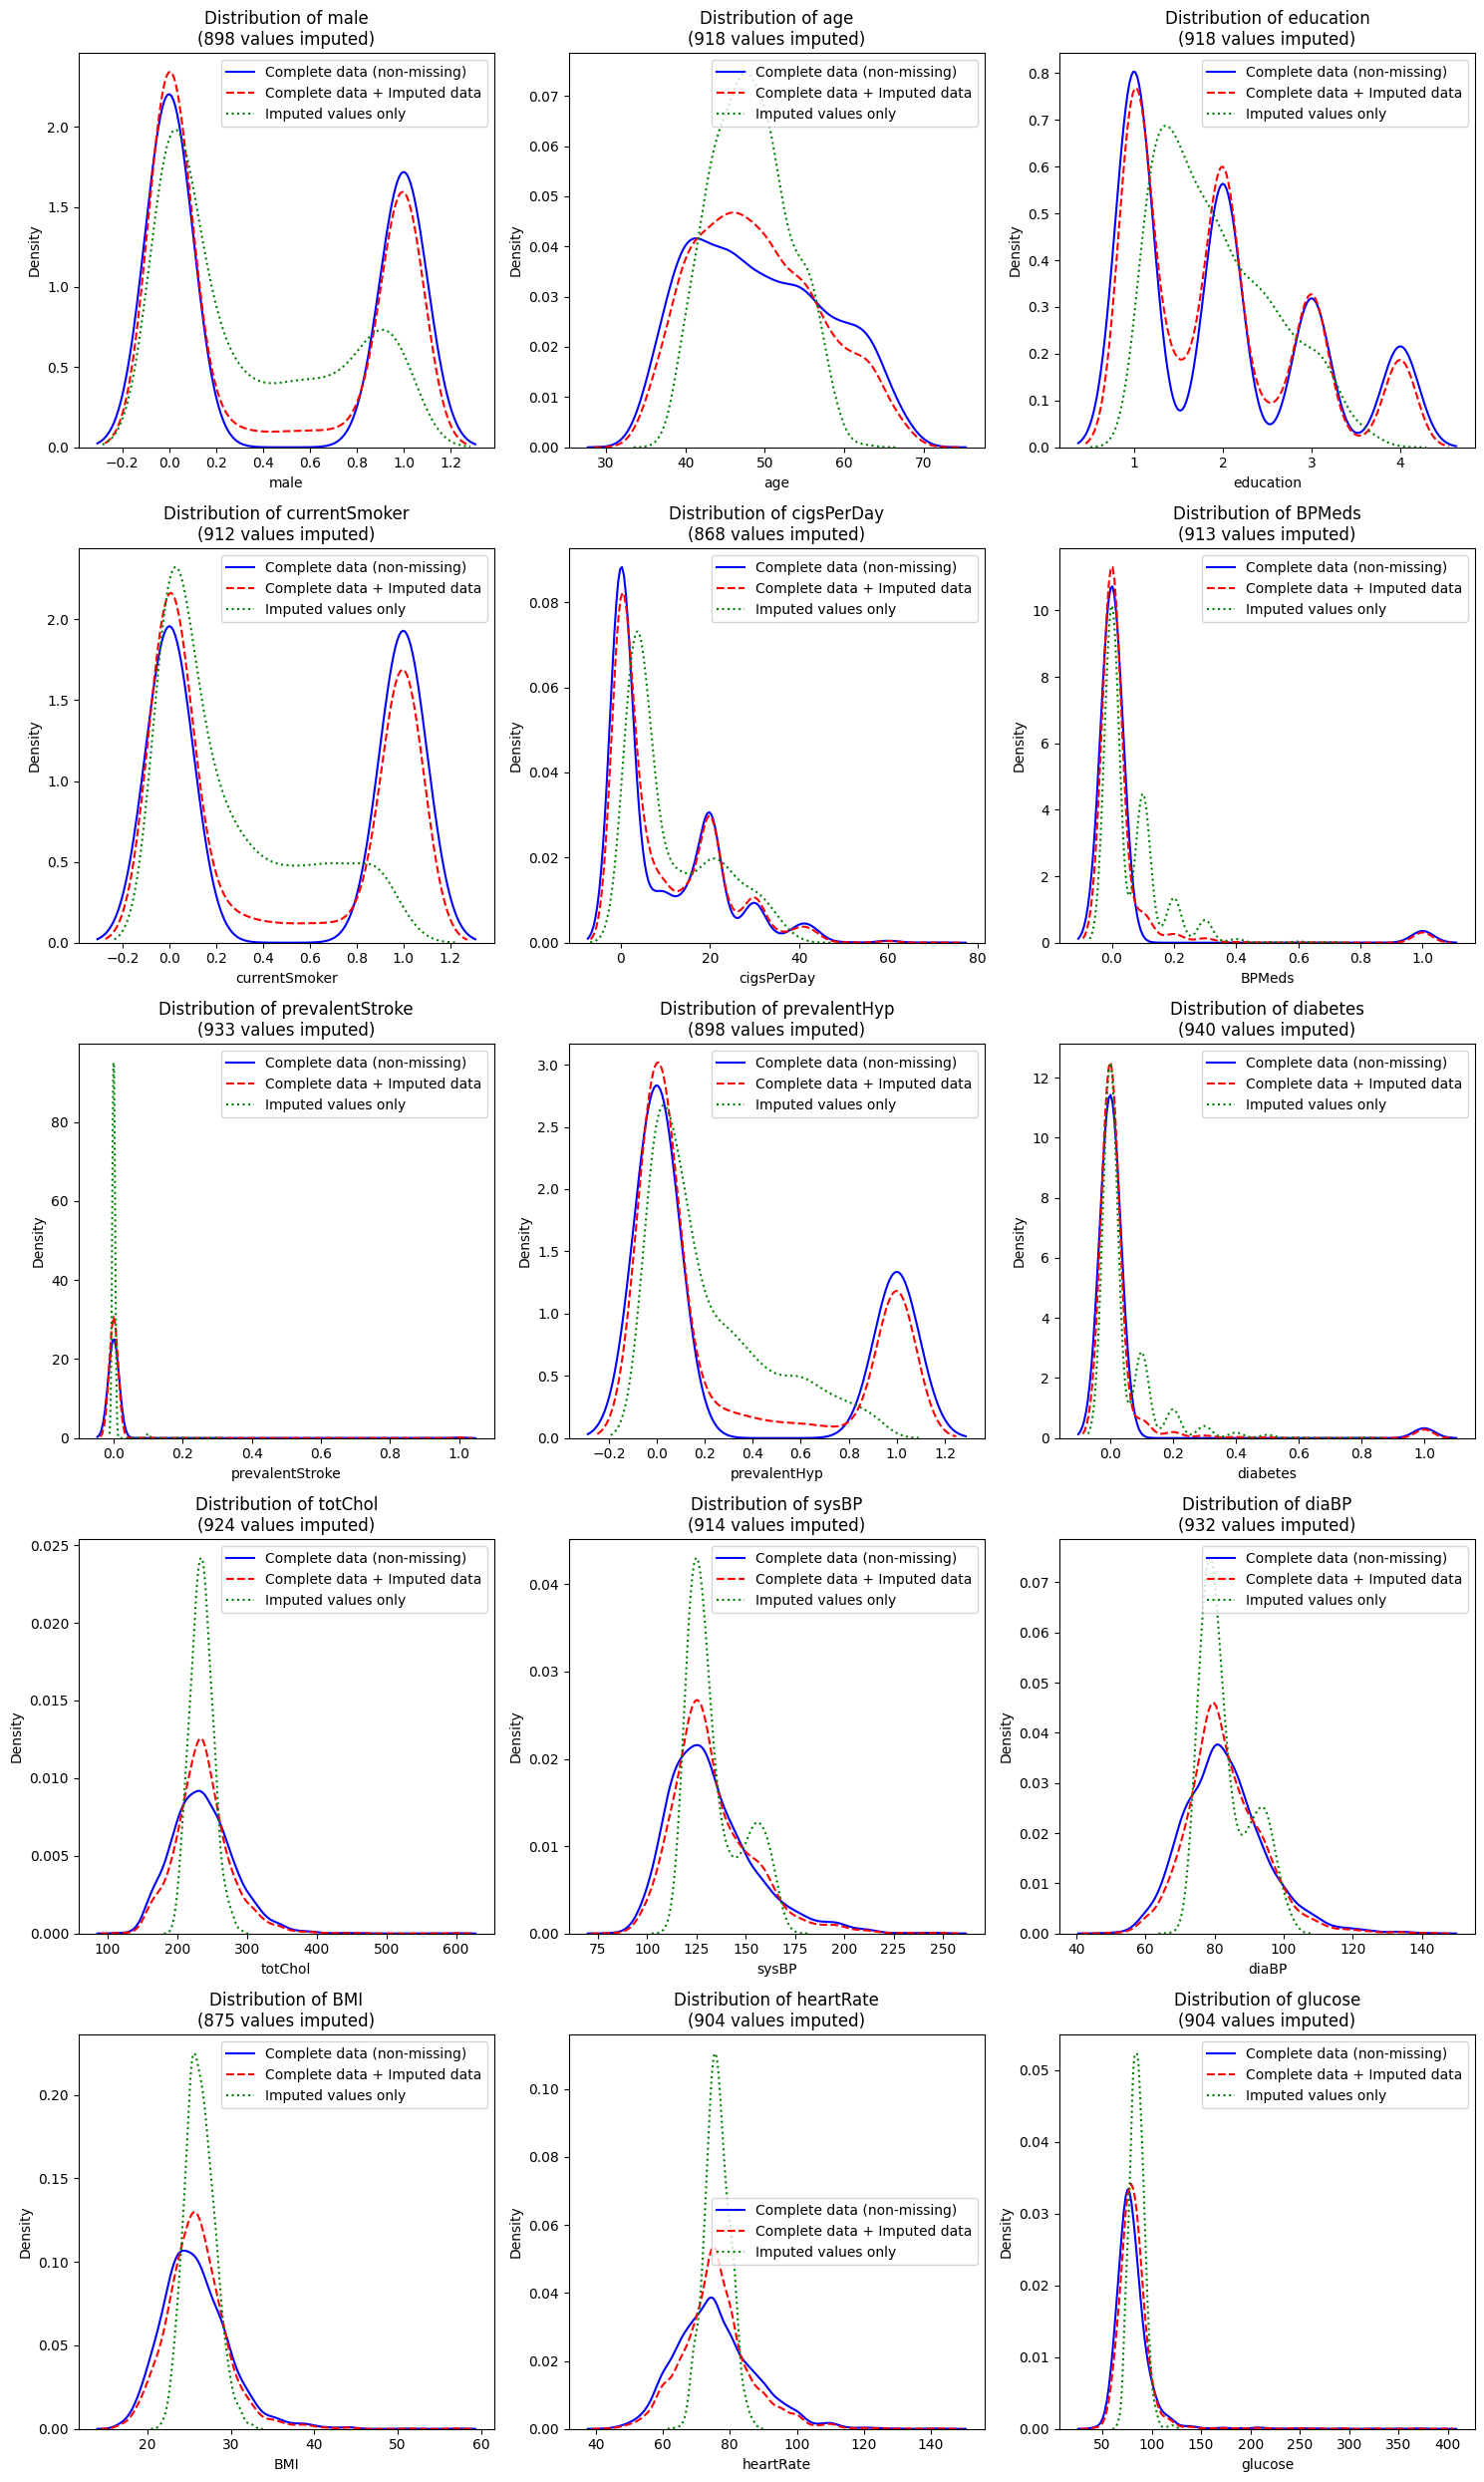

In [ ]:
## Test run EGAIN
from EGAIN import EGAIN # Import the EGAIN function/class

df = pd.read_csv('/content/drive/MyDrive/Monticello_Saghafi_HonorsThesis/framingham.csv').to_numpy(dtype=float)
egain_parameters = {'batch_size': 64, 'hint_rate': 0.90, 'alpha': 60, 'iterations': 2000}

data_x_np = data_x.to_numpy(dtype=float) # Convert data_x to NumPy array

df_imputed = EGAIN(data_x_np, egain_parameters, retrain=False, plots=True)
df_imputed = pd.DataFrame(df_imputed, columns=data_x.columns)
print(df_imputed.isnull().sum())
plot_imputation_results(data_x, df_imputed)

In [ ]:
import numpy as np
import pandas as pd

# NOTE: Ensure your data_x is fully numerical and scaled for EGAIN!
print("\n--- Running EGAIN Imputation ---")

# Define EGAIN parameters (adjust as needed)
egain_parameters = {'batch_size': 64, 'hint_rate': 0.90, 'alpha': 60, 'iterations': 1200}

# Convert DataFrame to NumPy array for the EGAIN function input
data_x_np = data_x.to_numpy(dtype=float)

# Run the EGAIN function (assumed to return a NumPy array)
imputed_data_np = EGAIN(data_x_np, egain_parameters)

# Convert NumPy array back to DataFrame (maintaining the generic name)
imputed_data = pd.DataFrame(imputed_data_np, columns=data_x.columns)

# ----------------------------------------------------
# REQUIRED ACTIONS
# ----------------------------------------------------
# 1. Save the unique result to the global dictionary
IMPUTED_RESULTS['egain'] = imputed_data.copy()

# 2. Run Evaluation and Display Table
egain_results_table = evaluate_imputation(
    x_true=x_df,
    x_missing=data_x,
    x_imputed=imputed_data,
    categorical_cols=IMPUTATION_CATEGORICAL_COLS
)

print("\nEGAIN Imputation Results Breakdown:\n")
display(egain_results_table.round(4))


--- Running EGAIN Imputation ---


100%|██████████| 1200/1200 [00:10<00:00, 116.37it/s]



--- OVERALL RESULTS (MEDIAN) ---
Average NRMSE (Continuous): 0.9643
Overall PFC (Categorical): 0.2684
--------------------------------


EGAIN Imputation Results Breakdown:



Type     RMSE   NRMSE     PFC  Imputed_Count
Variable                                                            
male             Categorical      NaN     NaN  0.4577            898
age               Continuous   8.8329  1.0316     NaN            918
education        Categorical      NaN     NaN  0.6264            918
currentSmoker    Categorical      NaN     NaN  0.4682            912
cigsPerDay        Continuous   9.4623  0.7937     NaN            868
BPMeds           Categorical      NaN     NaN  0.0263            913
prevalentStroke  Categorical      NaN     NaN  0.0054            933
prevalentHyp     Categorical      NaN     NaN  0.2851            898
diabetes         Categorical      NaN     NaN  0.0245            940
totChol           Continuous  43.6839  0.9906     NaN            924
sysBP             Continuous  18.7738  0.8500     NaN            914
diaBP             Continuous  10.6853  0.8924     NaN            932
BMI               Continuous   3.9126  0.9624     NaN            875
heartRate         Continuous  13.1187  1.0949     NaN            904
glucose           Continuous  26.2740  1.0991     NaN            904

## MIWAE

In [16]:
# MIWAE imputer (TensorFlow 2.x + TFP) — DataFrame in, DataFrame out
# -------------------------------------------------------------------

import tensorflow_probability as tfp

tfd  = tfp.distributions
tfk  = tf.keras
tfkl = tf.keras.layers

def MIWAE(xmiss, miwae_parameters=None):
    # ---------- Parameters ----------
    defaults = {
        'epochs': 600,
        'batch_size': 64,
        'K_train': 20,
        'K_eval': 1000,
        'lr': 1e-3,
        'hidden': 32,
        'latent_dim': None,
        'verbose': True,
        'seed': 1234,
    }
    if miwae_parameters is not None:
        defaults.update(miwae_parameters)
    epochs     = int(defaults['epochs'])
    batch_size = int(defaults['batch_size'])
    K_train    = int(defaults['K_train'])
    K_eval     = int(defaults['K_eval'])
    lr         = float(defaults['lr'])
    hidden     = int(defaults['hidden'])
    latent_dim = defaults['latent_dim']
    verbose    = bool(defaults['verbose'])
    seed       = int(defaults['seed'])

    # ---------- Data ----------
    if not isinstance(xmiss, pd.DataFrame):
        xmiss = pd.DataFrame(xmiss)
    cols = xmiss.columns
    idx  = xmiss.index

    xmiss_np = xmiss.to_numpy(dtype=np.float32, copy=True)
    n, p = xmiss_np.shape
    mask = np.isfinite(xmiss_np)     # True if observed
    x0   = np.copy(xmiss_np)
    x0[~mask] = 0.0                  # zeros for missing

    # ---------- Seeding ----------
    np.random.seed(seed)
    tf.keras.utils.set_random_seed(seed)

    # ---------- Latent prior ----------
    d = int(np.floor(p / 2)) if latent_dim is None else int(latent_dim)
    p_z = tfd.MultivariateNormalDiag(
        loc=tf.zeros([d], dtype=tf.float32),
        scale_diag=tf.ones([d], dtype=tf.float32)
    )

    # Trainable iota applied to missing entries only
    iota = tf.Variable(tf.zeros([1, p], dtype=tf.float32), name="iota")

    # ---------- Networks ----------
    # Encoder outputs mean and (positive) scale for a Gaussian q(z|x)
    encoder = tfk.Sequential(
        [
            tfkl.InputLayer(shape=(p,)),
            tfkl.Dense(hidden, activation="relu", kernel_initializer="orthogonal"),
            tfkl.Dense(hidden, activation="relu", kernel_initializer="orthogonal"),
            tfkl.Dense(2 * d, kernel_initializer="orthogonal"),  # CHANGED: 2*d (mu, scale)
        ],
        name="encoder",
    )

    # Decoder outputs Student-t params for p(x|z)
    decoder = tfk.Sequential(
        [
            tfkl.InputLayer(shape=(d,)),
            tfkl.Dense(hidden, activation="relu", kernel_initializer="orthogonal"),
            tfkl.Dense(hidden, activation="relu", kernel_initializer="orthogonal"),
            tfkl.Dense(3 * p, kernel_initializer="orthogonal"),
        ],
        name="decoder",
    )

    opt = tf.keras.optimizers.Adam(learning_rate=lr)

    @tf.function
    def _split_normal(params, feat_dim):
        loc   = params[..., :feat_dim]
        scale = tf.nn.softplus(params[..., feat_dim:]) + 1e-5
        return loc, scale

    @tf.function
    def _split_student(params, feat_dim):
        loc   = params[..., :feat_dim]
        scale = tf.nn.softplus(params[..., feat_dim : 2 * feat_dim]) + 1e-3
        df    = tf.nn.softplus(params[..., 2 * feat_dim : 3 * feat_dim]) + 3.0
        return loc, scale, df

    # ------ q(z|x): Gaussian (reparameterizable)  ------
    @tf.function
    def _q_z_given_x(x_batch, mask_batch):
        mask_f = tf.cast(mask_batch, tf.float32)
        x_in   = x_batch + (1.0 - mask_f) * iota
        enc_out = encoder(x_in)
        loc, scale = _split_normal(enc_out, d)
        q = tfd.MultivariateNormalDiag(loc=loc, scale_diag=scale)  # CHANGED: Normal q
        return q

    @tf.function
    def _decoder_params(z_flat):
        dec_out = decoder(z_flat)
        mu, sc, df = _split_student(dec_out, p)  # Student-t likelihood
        return mu, sc, df

    @tf.function
    def _miwae_batch_loss(x_batch, mask_batch, K: tf.Tensor):
        B = tf.shape(x_batch)[0]
        q = _q_z_given_x(x_batch, mask_batch)           # q(z|x)
        z = q.sample(K)                                 # (K, B, d), pathwise OK
        z_flat = tf.reshape(z, (K * B, d))              # (K*B, d)

        mu, sc, df = _decoder_params(z_flat)
        mu = tf.reshape(mu, (K, B, p))
        sc = tf.reshape(sc, (K, B, p))
        df = tf.reshape(df, (K, B, p))

        dist_x = tfd.StudentT(loc=mu, scale=sc, df=df)  # p(x|z)
        x_exp  = tf.expand_dims(x_batch, axis=0)        # (1, B, p)
        m_exp  = tf.cast(tf.expand_dims(mask_batch, axis=0), tf.float32)

        log_px = tf.reduce_sum(dist_x.log_prob(x_exp) * m_exp, axis=-1)   # (K, B)
        log_pz = p_z.log_prob(z)                                          # (K, B)
        log_q  = q.log_prob(z)                                            # (K, B)
        log_w  = log_px + log_pz - log_q

        logsumexp_k = tf.reduce_logsumexp(log_w, axis=0)                  # (B,)
        loss = -tf.reduce_mean(logsumexp_k - tf.math.log(tf.cast(K, tf.float32)))
        return loss, log_w

    # ---------- Data pipeline ----------
    indices = np.arange(n)
    def _batch_iter():
        np.random.shuffle(indices)
        for s in range(0, n, batch_size):
            e = min(s + batch_size, n)
            take = indices[s:e]
            yield x0[take].astype(np.float32, copy=False), mask[take]

    x0_tf   = tf.constant(x0, dtype=tf.float32)
    mask_tf = tf.constant(mask, dtype=tf.bool)

    @tf.function
    def _eval_full_bound(K: tf.Tensor):
        loss, _ = _miwae_batch_loss(x0_tf, mask_tf, tf.cast(K, tf.int32))
        return -loss

    history = {"epoch": [], "miwae_bound": []}

    # ---------- Training ----------
    for ep in range(1, epochs + 1):
        for xb, mb in _batch_iter():
            xb_tf = tf.convert_to_tensor(xb, dtype=tf.float32)
            mb_tf = tf.convert_to_tensor(mb, dtype=tf.bool)
            with tf.GradientTape() as tape:
                loss, _ = _miwae_batch_loss(xb_tf, mb_tf, tf.constant(K_train, tf.int32))
            vars_ = (
                encoder.trainable_variables +
                decoder.trainable_variables +
                [iota]
            )
            grads = tape.gradient(loss, vars_)
            opt.apply_gradients(zip(grads, vars_))

        if verbose and (ep % 200 == 1 or ep == epochs):
            bound = _eval_full_bound(tf.constant(K_train, tf.int32)).numpy().item()
            history["epoch"].append(ep)
            history["miwae_bound"].append(bound)
            print(f"[Epoch {ep:4d}] MIWAE bound: {bound: .4f}")

    # ---------- Imputation ----------
    @tf.function
    def _impute_batch(x_batch, mask_batch, K: tf.Tensor):
        B = tf.shape(x_batch)[0]
        q = _q_z_given_x(x_batch, mask_batch)
        z = q.sample(K)                               # (K, B, d)
        z_flat = tf.reshape(z, (K * B, d))

        mu, sc, df = _decoder_params(z_flat)
        mu = tf.reshape(mu, (K, B, p))
        sc = tf.reshape(sc, (K, B, p))
        df = tf.reshape(df, (K, B, p))

        x_exp  = tf.expand_dims(x_batch, axis=0)
        m_exp  = tf.cast(tf.expand_dims(mask_batch, axis=0), tf.float32)

        dist_x = tfd.StudentT(loc=mu, scale=sc, df=df)
        log_px = tf.reduce_sum(dist_x.log_prob(x_exp) * m_exp, axis=-1)   # (K, B)
        log_pz = p_z.log_prob(z)                                          # (K, B)
        log_q  = q.log_prob(z)                                            # (K, B)
        w = tf.nn.softmax(log_px + log_pz - log_q, axis=0)                # (K, B)

        # Predictive mean of x|z under Student-t is its location mu
        x_ms   = mu                                                       # (K, B, p)
        x_mean = tf.einsum("kb,kbp->bp", w, x_ms)                         # (B, p)
        return x_mean

    x_imputed = np.array(xmiss_np, copy=True)
    for s in range(0, n, batch_size):
        e = min(s + batch_size, n)
        xb = x0[s:e].astype(np.float32, copy=False)
        mb = mask[s:e]
        xm = _impute_batch(
            tf.convert_to_tensor(xb, dtype=tf.float32),
            tf.convert_to_tensor(mb, dtype=tf.bool),
            tf.constant(K_eval, tf.int32),
        ).numpy()
        block_miss = ~mb
        x_block = x_imputed[s:e]
        x_block[block_miss] = xm[block_miss]
        x_imputed[s:e] = x_block

    x_imputed_df = pd.DataFrame(x_imputed, index=idx, columns=cols)
    return x_imputed_df, history

[Epoch    1] MIWAE bound: -131.8675
[Epoch  201] MIWAE bound: -16.6577
[Epoch  401] MIWAE bound: -12.5693
[Epoch  600] MIWAE bound: -10.8503
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3658 entries, 0 to 3657
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   male             3658 non-null   float64
 1   age              3658 non-null   float64
 2   education        3658 non-null   float64
 3   currentSmoker    3658 non-null   float64
 4   cigsPerDay       3658 non-null   float64
 5   BPMeds           3658 non-null   float64
 6   prevalentStroke  3658 non-null   float64
 7   prevalentHyp     3658 non-null   float64
 8   diabetes         3658 non-null   float64
 9   totChol          3658 non-null   float64
 10  sysBP            3658 non-null   float64
 11  diaBP            3658 non-null   float64
 12  BMI              3658 non-null   float64
 13  heartRate        3658 non-null   float64
 14  glucose    

/tmp/ipython-input-2384667375.py:36: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
/tmp/ipython-input-2384667375.py:36: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
/tmp/ipython-input-2384667375.py:36: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
/tmp/ipython-input-2384667375.py:36: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.


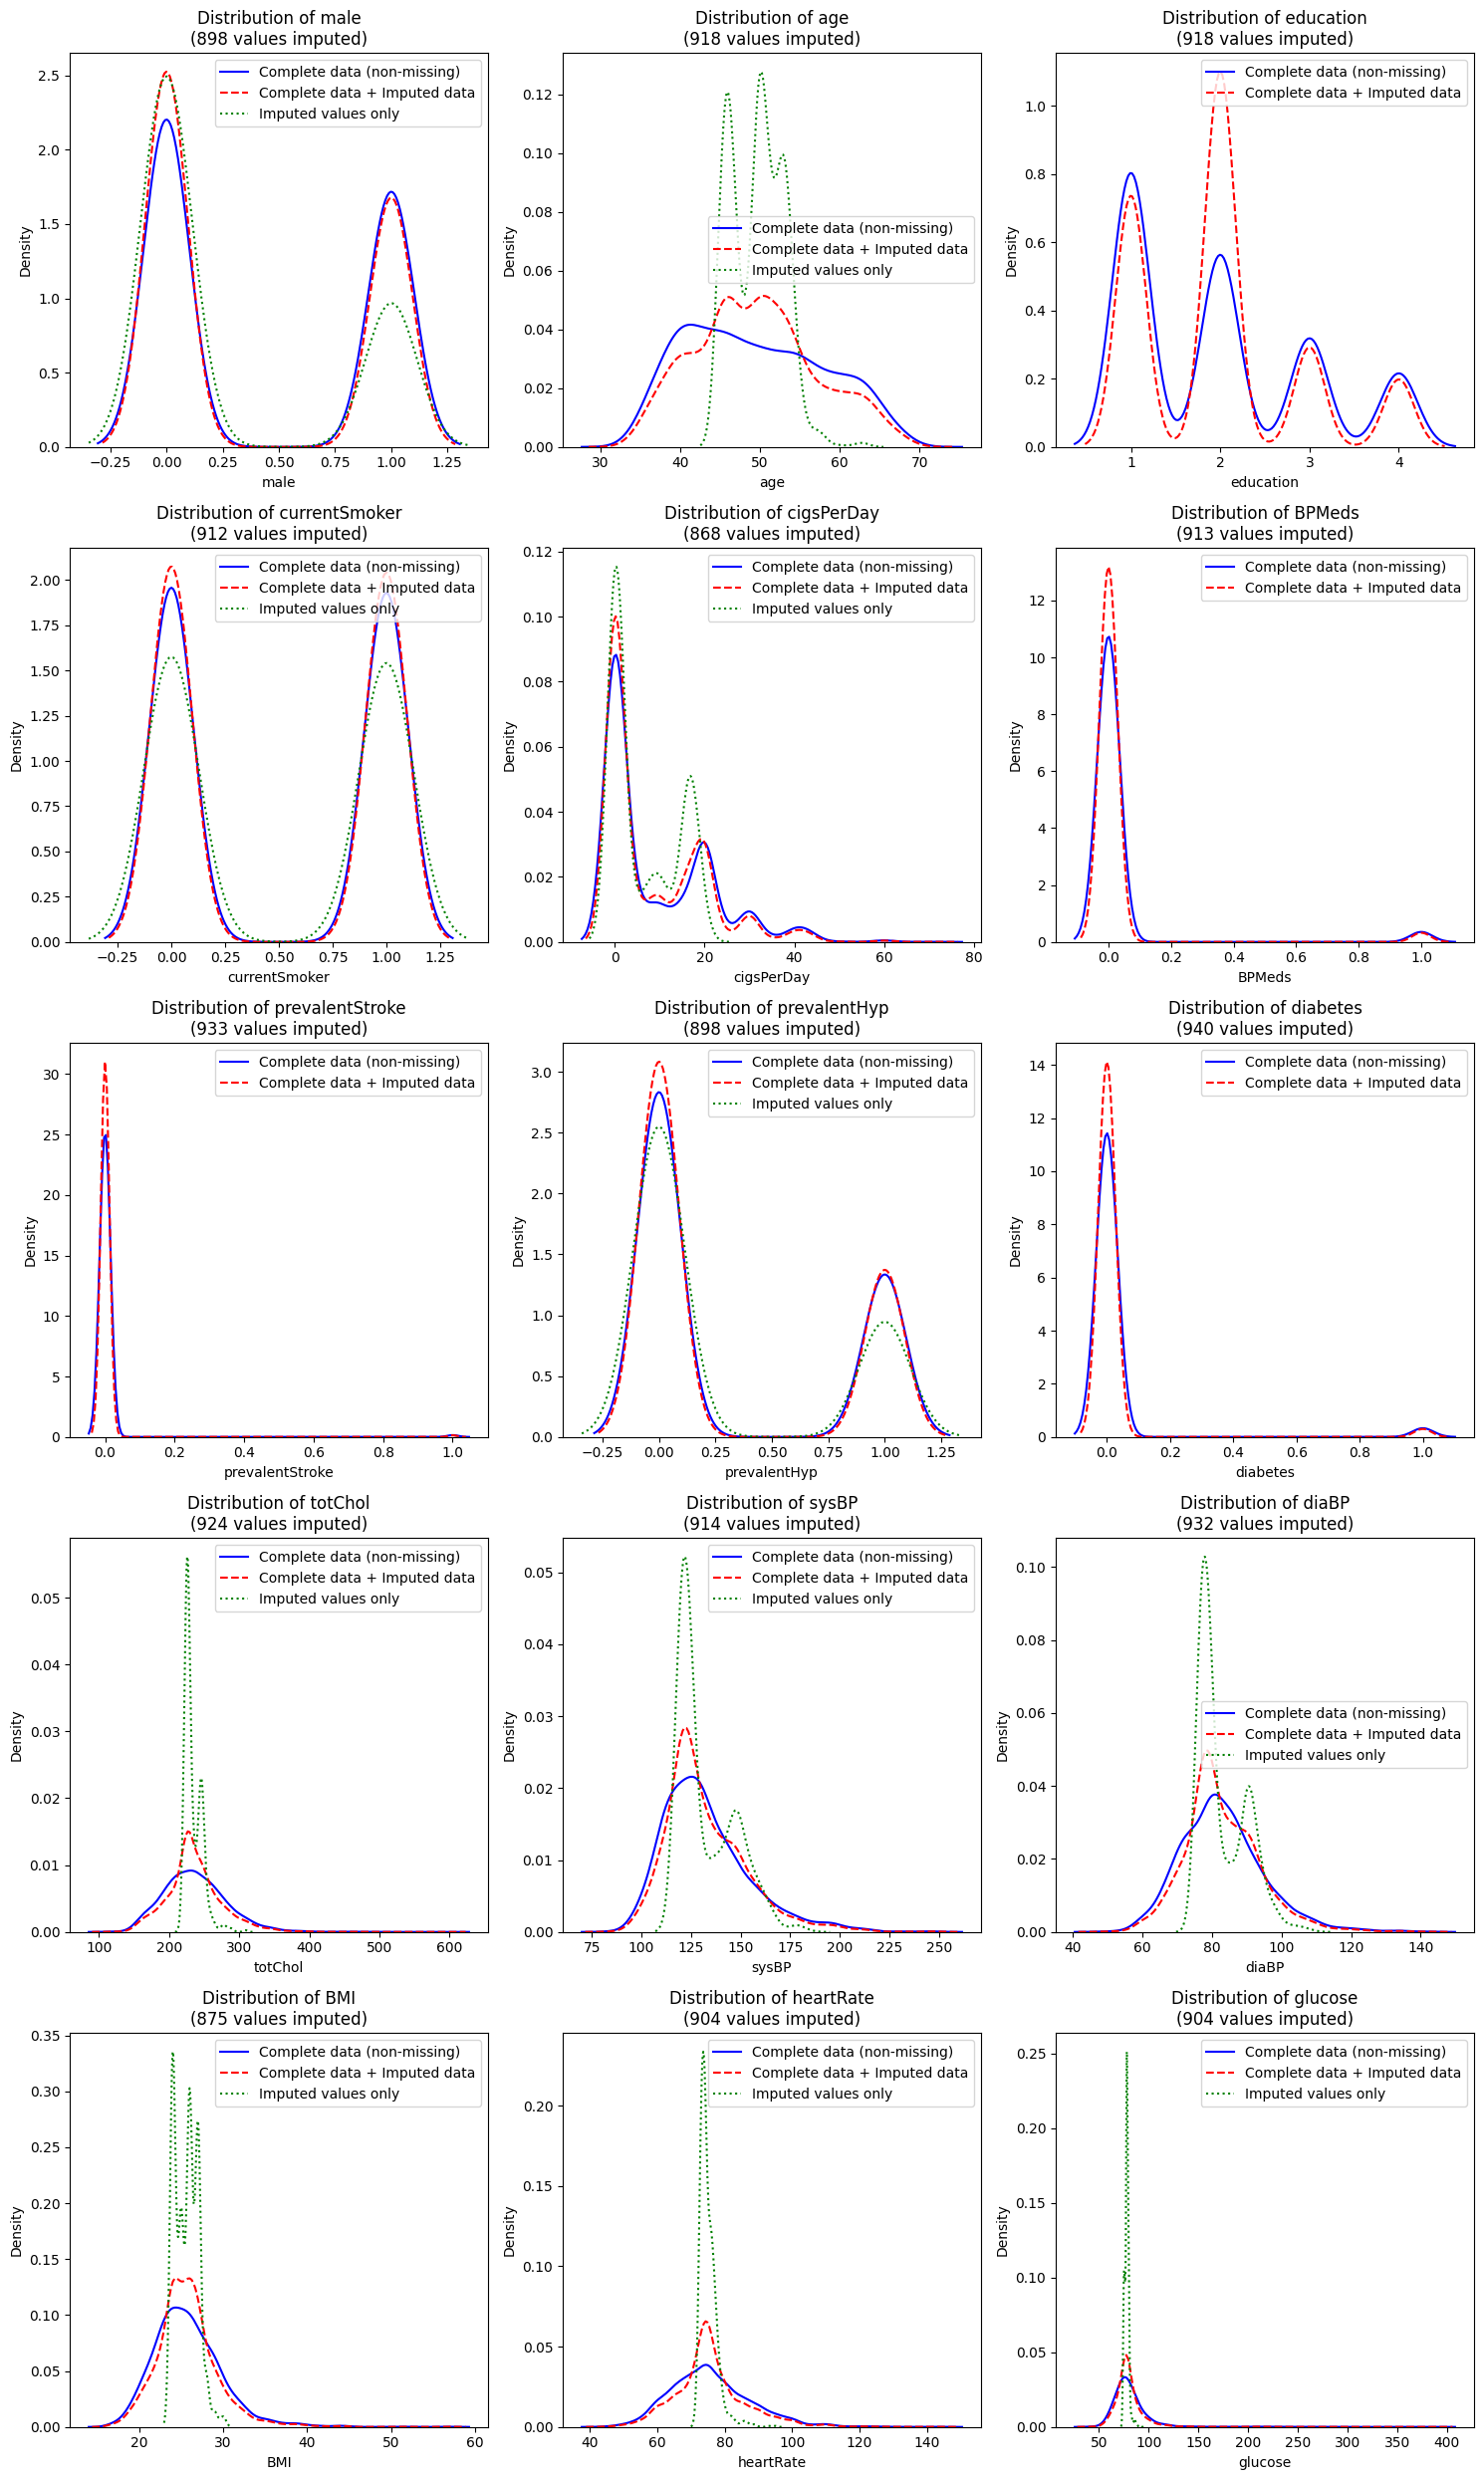

In [ ]:
## Test Run MIWAE
df = pd.read_csv('/content/drive/MyDrive/Monticello_Saghafi_HonorsThesis/framingham.csv')
miwae_parameters = {'epochs':600, 'batch_size':64, 'K_train':20, 'K_eval':1000, 'lr':1e-3, 'hidden':32, 'latent_dim':None, 'verbose':True, 'seed':2026}
df_imputed, hist = MIWAE(data_x, miwae_parameters)
df_imputed = pd.DataFrame(df_imputed, columns=data_x.columns)
df_imputed = round_like(df_imputed, data_x)
df_imputed.info()
plot_imputation_results(data_x, df_imputed)

In [21]:
import numpy as np
import pandas as pd

# Assuming the MIWAE function is defined and handles the necessary data conversion
print("\n--- Running MIWAE Imputation ---")

miwae_parameters = {'epochs':600, 'batch_size':64, 'K_train':20, 'K_eval':1000, 'lr':1e-3, 'hidden':32, 'latent_dim':None, 'verbose':False, 'seed':2026}

# Run the MIWAE function (Note: it might return a NumPy array or DataFrame depending on your function)
imputed_data_np, hist = MIWAE(data_x, miwae_parameters)

# Assuming MIWAE returned a NumPy array, convert it back:
imputed_data = pd.DataFrame(imputed_data_np, columns=data_x.columns)

# NOTE: If you used a 'round_like' function previously, apply it here!
# imputed_data = round_like(imputed_data, x)

# ----------------------------------------------------
# REQUIRED ACTIONS
# ----------------------------------------------------
# 1. Save the unique result to the global dictionary
IMPUTED_RESULTS['miwae'] = imputed_data.copy()

# Convert 'x' (numpy array) to DataFrame for evaluate_imputation function
x_df = pd.DataFrame(x, columns=df.columns[:-1])

# 2. Run Evaluation and Display Table
miwae_results_table = evaluate_imputation(
    x_true=x_df,
    x_missing=data_x,
    x_imputed=imputed_data,
    categorical_cols=IMPUTATION_CATEGORICAL_COLS
)

print("\nMIWAE Imputation Results Breakdown:\n")
display(miwae_results_table.round(4))


--- Running MIWAE Imputation ---

--- OVERALL RESULTS (MEDIAN) ---
Average NRMSE (Continuous): 0.9078
Overall PFC (Categorical): 0.2520
--------------------------------


MIWAE Imputation Results Breakdown:



Type     RMSE   NRMSE     PFC  Imputed_Count
Variable                                                            
male             Categorical      NaN     NaN  0.4610            898
age               Continuous   8.0070  0.9352     NaN            918
education        Categorical      NaN     NaN  0.6198            918
currentSmoker    Categorical      NaN     NaN  0.3925            912
cigsPerDay        Continuous  10.1997  0.8556     NaN            868
BPMeds           Categorical      NaN     NaN  0.0263            913
prevalentStroke  Categorical      NaN     NaN  0.0054            933
prevalentHyp     Categorical      NaN     NaN  0.2483            898
diabetes         Categorical      NaN     NaN  0.0245            940
totChol           Continuous  42.0156  0.9528     NaN            924
sysBP             Continuous  15.7629  0.7137     NaN            914
diaBP             Continuous   9.3097  0.7775     NaN            932
BMI               Continuous   3.8952  0.9581     NaN            875
heartRate         Continuous  11.8034  0.9851     NaN            904
glucose           Continuous  25.9292  1.0847     NaN            904

# Loop Run

The datasets in this section are complete dataset with no missing. We generate missing values in the data using random seeds, seeds are stored, then impute the missing data using different techniques and calculate performance metrics. Average performance over different seeds are reported as the final comparison metric.

### beast cancer
* Breast Cancer Wisconsin
* 569 Cases, 31 Vars (30 numerical: radius, texture, perimeter, area, smoothness, compactness, concavity, concave points, symmetry, fractal dimension; 1 categorical: Benign/Malignant)
* MCAR (5 vars)
* The response var will not have missing, the goal is not predicitive analysis but impute plausible missing




#### Median imputation

In [ ]:
# All Loops Run
random_seeds = [323, 1034, 1381, 1909, 2428, 3301, 3703, 3937, 4256, 4503, 4516, 4753, 5160, 5331,
                5487, 5705, 5910, 6608, 6718, 7883, 8621, 9024, 9360, 9422, 9428, 9531, 9721, 9887, 9910, 9995]

full_data = pd.read_csv('/content/drive/MyDrive/CXR/breast.csv').values

# Store all results
all_results = []

# Define miss_rate values
#miss_rate_pairs = [0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70]
miss_rate_pairs = [0.25, 0.50, 0.75]

# Loop through different missing rates
for miss_rate in miss_rate_pairs:
    median_time = []
    median_rmse = []

    print(f"Running for miss_rate: {miss_rate:.2f}")

    for run in range(30):
        seed = random_seeds[run]

        # Generate missing data
        data_x = mcar_missing(full_data[:, 1:], ncols=16, miss_rate=miss_rate, random_seed=seed)
        data_x = np.insert(data_x, 0, full_data[:, 0], axis=1)

        # Impute missing
        start_time = time.time()
        df_x = pd.DataFrame(data_x)
        imputed_data = df_x.fillna(df_x.median())
        end_time = time.time()

        # Store metrics
        median_time.append(end_time - start_time)
        median_rmse.append(rmse_loss(full_data, data_x, imputed_data))

    # Store DataFrame per miss_rate
    df = pd.DataFrame({
        'miss_rate': [miss_rate]*30,
        'run': list(range(30)),
        'time_': median_time,
        'rmse_': median_rmse
    })

    all_results.append(df)

# Concatenate all results
final_results = pd.concat(all_results, ignore_index=True)
final_results.to_csv('/content/final_results.csv', index=False)
print(final_results)

Running for miss_rate: 0.25
Running for miss_rate: 0.50
Running for miss_rate: 0.75
    miss_rate  run     time_     rmse_
0        0.25    0  0.007817  0.039819
1        0.25    1  0.008081  0.034389
2        0.25    2  0.007866  0.035530
3        0.25    3  0.010979  0.034121
4        0.25    4  0.009297  0.039437
..        ...  ...       ...       ...
85       0.75   25  0.006760  0.063306
86       0.75   26  0.006921  0.062516
87       0.75   27  0.006675  0.062069
88       0.75   28  0.007680  0.065119
89       0.75   29  0.007198  0.061826

[90 rows x 4 columns]


#### TF1 GAIN

In [ ]:
## FIRST RUN TF1 BLOCK
##-------------------
# Set seed for reproducibility
np.random.seed(25)

# Load DataFrame
##--------------------
## import data with missing
full_data = pd.read_csv('/content/drive/MyDrive/CXR/breast.csv').values
# Set GAIN params
gain_parameters = {'batch_size': 64, 'hint_rate': 0.90, 'alpha': 80, 'iterations': 250}

# Store results
gain_time  = []
gain_rmse = []

# Perform 25 runs
##--------------------
for run in range(1, 26):
    ## Generate missing
    data_x = mcar_missing(full_data[:,1:], ncols=16, miss_rate=0.75, random_seed=25)
    data_x = np.insert(data_x, 0, full_data[:,0], axis=1)

    ## Impute Missing
    tf.keras.backend.clear_session()
    start_time = time.time()
    imputed_data = gain(data_x, gain_parameters)
    end_time = time.time()
    gain_time.append(end_time - start_time)
    gain_rmse.append(rmse_loss(full_data, data_x, imputed_data))


#  DataFrame all results
results = pd.DataFrame()
results['time_'] = gain_time
results['rmse_'] = gain_rmse
results.to_csv('/content/results.csv')
print(results)

100%|██████████| 250/250 [00:00<00:00, 303.26it/s]


       time_     rmse_
0   4.014165  0.049325
1   4.508783       NaN
2   1.981611       NaN
3   2.114159  0.048404
4   1.657138  0.050795
5   1.293272  0.047911
6   1.347194  0.048810
7   1.331502  0.048271
8   1.372080       NaN
9   1.338450  0.045128
10  2.019680       NaN
11  1.957960       NaN
12  1.323090       NaN
13  1.291692  0.048050
14  1.329184       NaN
15  1.327177       NaN
16  1.445535  0.048747
17  1.371545       NaN
18  2.054472  0.049725
19  1.921937       NaN
20  1.380319       NaN
21  1.373794       NaN
22  1.366955       NaN
23  1.388519  0.047342
24  1.338727  0.049044


#### MICE

#### MissForest

#### TF2 EGAIN

### spam
* 4,601 Cases, 57 vars (57 numerical: Cont 1 -- Cont 57)
* MCAR (10 vars)
* MCAR (all vars)

#### Median

In [ ]:
## Median
##-------------------
# Set seed for reproducibility
np.random.seed(25)

# Load DataFrame
##--------------------
## import data with missing
full_data = pd.read_csv('/content/drive/MyDrive/CXR/spam.csv').values

# Store results
median_time  = []
median_rmse = []

# Perform 100 runs
##--------------------
for run in range(25):
  seed = random_seeds[run]
  ## Generate missing
  data_x = mcar_missing(full_data, ncols=0, miss_rate=0.70, random_seed=seed)

  ## Impute Missing
  start_time = time.time()
  df_x = pd.DataFrame(data_x)
  imputed_data = df_x.fillna(df_x.median())
  end_time = time.time()
  median_time.append(end_time - start_time)
  median_rmse.append(rmse_loss(full_data, data_x, imputed_data))

#  DataFrame all results
results = pd.DataFrame()
results['time_'] = median_time
results['rmse_'] = median_rmse
results.to_csv('/content/results_median_10.csv')
print(results)
print(results.describe())

       time_     rmse_
0   0.068615  0.045133
1   0.038626  0.044890
2   0.027499  0.045813
3   0.022516  0.045344
4   0.019954  0.044659
5   0.018360  0.045014
6   0.018469  0.045300
7   0.018706  0.045814
8   0.018392  0.045194
9   0.019149  0.044654
10  0.029122  0.044659
11  0.017789  0.045395
12  0.018423  0.045246
13  0.019215  0.045174
14  0.018559  0.045491
15  0.020262  0.044933
16  0.019480  0.045477
17  0.018263  0.045414
18  0.017838  0.046211
19  0.018573  0.045423
20  0.018263  0.045581
21  0.020971  0.045432
22  0.021239  0.046408
23  0.021176  0.045360
24  0.019850  0.045198
           time_      rmse_
count  25.000000  25.000000
mean    0.022772   0.045329
std     0.010609   0.000431
min     0.017789   0.044654
25%     0.018423   0.045133
50%     0.019215   0.045344
75%     0.021176   0.045477
max     0.068615   0.046408


In [ ]:
# All Loops Run
random_seeds = [324, 1035, 1382, 1920, 2429, 3302, 3704, 3938, 4258, 4502, 4517, 4754, 5161, 5332,
                5488, 5706, 5911, 6609, 6719, 7882, 8622, 9025, 9361, 9423, 9428, 9531, 9721, 9887, 9910, 9995]

full_data = pd.read_csv('/content/drive/MyDrive/CXR/spam.csv').values

# Store all results
all_results = []

# Define miss_rate values
#miss_rate_pairs = [0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70]
miss_rate_pairs = [0.25, 0.50, 0.75]

# Loop through different missing rates
for miss_rate in miss_rate_pairs:
    median_time = []
    median_rmse = []

    print(f"Running for miss_rate: {miss_rate:.2f}")

    for run in range(30):
        seed = random_seeds[run]

        # Generate missing data
        data_x = mcar_missing(full_data[:, 1:], ncols=2, miss_rate=miss_rate, random_seed=seed)
        data_x = np.insert(data_x, 0, full_data[:, 0], axis=1)

        # Impute missing
        start_time = time.time()
        df_x = pd.DataFrame(data_x)
        imputed_data = df_x.fillna(df_x.median())
        end_time = time.time()

        # Store metrics
        median_time.append(end_time - start_time)
        median_rmse.append(rmse_loss(full_data, data_x, imputed_data))

    # Store DataFrame per miss_rate
    df = pd.DataFrame({
        'miss_rate': [miss_rate]*30,
        'run': list(range(30)),
        'time_': median_time,
        'rmse_': median_rmse
    })

    all_results.append(df)

# Concatenate all results
final_results = pd.concat(all_results, ignore_index=True)
final_results.to_csv('/content/final_results.csv', index=False)
print(final_results)

Running for miss_rate: 0.25
Running for miss_rate: 0.50
Running for miss_rate: 0.75
    miss_rate  run     time_     rmse_
0        0.25    0  0.046676  0.000752
1        0.25    1  0.038191  0.001343
2        0.25    2  0.050366  0.001357
3        0.25    3  0.023731  0.000475
4        0.25    4  0.024294  0.001419
..        ...  ...       ...       ...
85       0.75   25  0.014794  0.002298
86       0.75   26  0.014504  0.002631
87       0.75   27  0.016881  0.001701
88       0.75   28  0.015343  0.001988
89       0.75   29  0.020569  0.001972

[90 rows x 4 columns]


#### TF1 GAIN

In [ ]:
## FIRST RUN TF1 BLOCK
##-------------------
# Set seed for reproducibility
np.random.seed(25)

# Load DataFrame
##--------------------
## import data with missing
full_data = pd.read_csv('/content/drive/MyDrive/CXR/spam.csv').values
# Set GAIN params
gain_parameters = {'batch_size': 64, 'hint_rate': 0.90, 'alpha': 30, 'iterations': 150} # REMEMBER

# Store results
gain_time  = []
gain_rmse = []

# Perform 100 runs
##--------------------
for run in range(1, 26):
    ## Generate missing
    data_x = mcar_missing(full_data, ncols=16, miss_rate=0.75, random_seed=25)

    ## Impute Missing
    tf.keras.backend.clear_session()
    start_time = time.time()
    imputed_data = gain(data_x, gain_parameters)
    end_time = time.time()
    gain_time.append(end_time - start_time)
    gain_rmse.append(rmse_loss(full_data, data_x, imputed_data))

#  DataFrame all results
results = pd.DataFrame()
results['time_'] = gain_time
results['rmse_'] = gain_rmse
results.to_csv('/content/results.csv')
print(results)
print(results.describe())

100%|██████████| 150/150 [00:00<00:00, 164.78it/s]


       time_     rmse_
0   1.163060       NaN
1   1.150633       NaN
2   1.124205  0.010157
3   1.182314  0.010062
4   1.154557  0.009904
5   1.705656  0.010041
6   1.733693  0.010178
7   1.129311  0.009915
8   1.151133  0.010071
9   1.135952  0.009908
10  1.149841       NaN
11  1.157921  0.009973
12  1.177145       NaN
13  1.145281  0.010032
14  1.755384       NaN
15  1.672212       NaN
16  1.140659  0.009915
17  1.145744  0.010052
18  1.171906       NaN
19  1.172282       NaN
20  1.160177       NaN
21  1.144782  0.010081
22  1.142359       NaN
23  1.696713  0.010129
24  1.598375  0.009995
           time_      rmse_
count  25.000000  15.000000
mean    1.282452   0.010027
std     0.237576   0.000091
min     1.124205   0.009904
25%     1.145281   0.009944
50%     1.157921   0.010041
75%     1.182314   0.010076
max     1.755384   0.010178


#### TF2 EGAIN

In [ ]:
## EGAIN_CC
##-------------------
# Set seed for reproducibility
np.random.seed(25)

# Load DataFrame
##--------------------
## import data with missing
full_data = pd.read_csv('/content/drive/MyDrive/CXR/spam.csv').values

# Store results
egain_time  = []
egain_rmse = []

# Perform 100 runs
##--------------------
for run in range(1, 26):
  ## Generate missing
  data_x = mcar_missing(full_data, ncols=0, miss_rate=0.2, random_seed=25)
  #print('percentage missing:', np.isnan(data_x).sum()/np.prod(data_x.shape))

  ## Impute Missing
  tf.keras.backend.clear_session()
  start_time = time.time()
  egain_parameters = {'batch_size': 96, 'hint_rate': 0.90, 'alpha': 80, 'iterations': 1000}
  imputed_data = EGAIN_CC(data_x, egain_parameters) # plots=True
  egain_parameters = {'batch_size': 96, 'hint_rate': 0.90, 'alpha': 80, 'iterations': 500}
  imputed_data = EGAIN_CC(data_x, egain_parameters, retrain=True) # plots=True
  end_time = time.time()
  egain_time.append(end_time - start_time)
  # Performance
  egain_rmse.append(rmse_loss(full_data, data_x, imputed_data))

#  DataFrame all results
results = pd.DataFrame()
results['time_'] = egain_time
results['rmse_'] = egain_rmse
results.to_csv('/content/results.csv')
print(results)
print(results.describe())

100%|██████████| 500/500 [00:09<00:00, 50.14it/s]


        time_     rmse_
0   32.198321  0.022576
1   35.967203  0.022582
2   33.436548  0.022599
3   33.286738  0.022587
4   34.223665  0.022589
5   32.679207  0.022602
6   34.284047  0.022588
7   32.338812  0.022593
8   33.670414  0.022580
9   34.727806  0.022581
10  34.387703  0.022592
11  33.967072  0.022582
12  34.627702  0.022577
13  34.187671  0.022582
14  32.185497  0.022604
15  33.417289  0.022593
16  32.070629  0.022603
17  33.835278  0.022579
18  31.938993  0.022572
19  33.084348  0.022596
20  31.887015  0.022574
21  32.617608  0.022583
22  31.864606  0.022580
23  31.981642  0.022587
24  31.546292  0.022597
           time_      rmse_
count  25.000000  25.000000
mean   33.216484   0.022587
std     1.153730   0.000009
min    31.546292   0.022572
25%    32.185497   0.022580
50%    33.286738   0.022587
75%    34.187671   0.022593
max    35.967203   0.022604
